Moving to a new noteboot to do the models better.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
from astropy.visualization import simple_norm
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy.stats import SigmaClip
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from astropy.time import Time
from scipy.optimize import leastsq
from scipy.stats import chisquare



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [37]:
nuvpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/'
nuvspecs = glob.glob('{}*fits'.format(nuvpath))
nuvspecs

['/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj1132_g230l_v23_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj1214_g230l_v22_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj581_g230l_v22_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj699_g230l_v23_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj876_g230l_v22_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_l-980-5_g230l_v23_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_lhs-2686_g230l_v23_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_lp-791-18_g230l_v23_component-spec.fits']

/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj581_g230l_v22_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj699_g230l_v23_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj876_g230l_v22_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_lhs-2686_g230l_v23_component-spec.fits


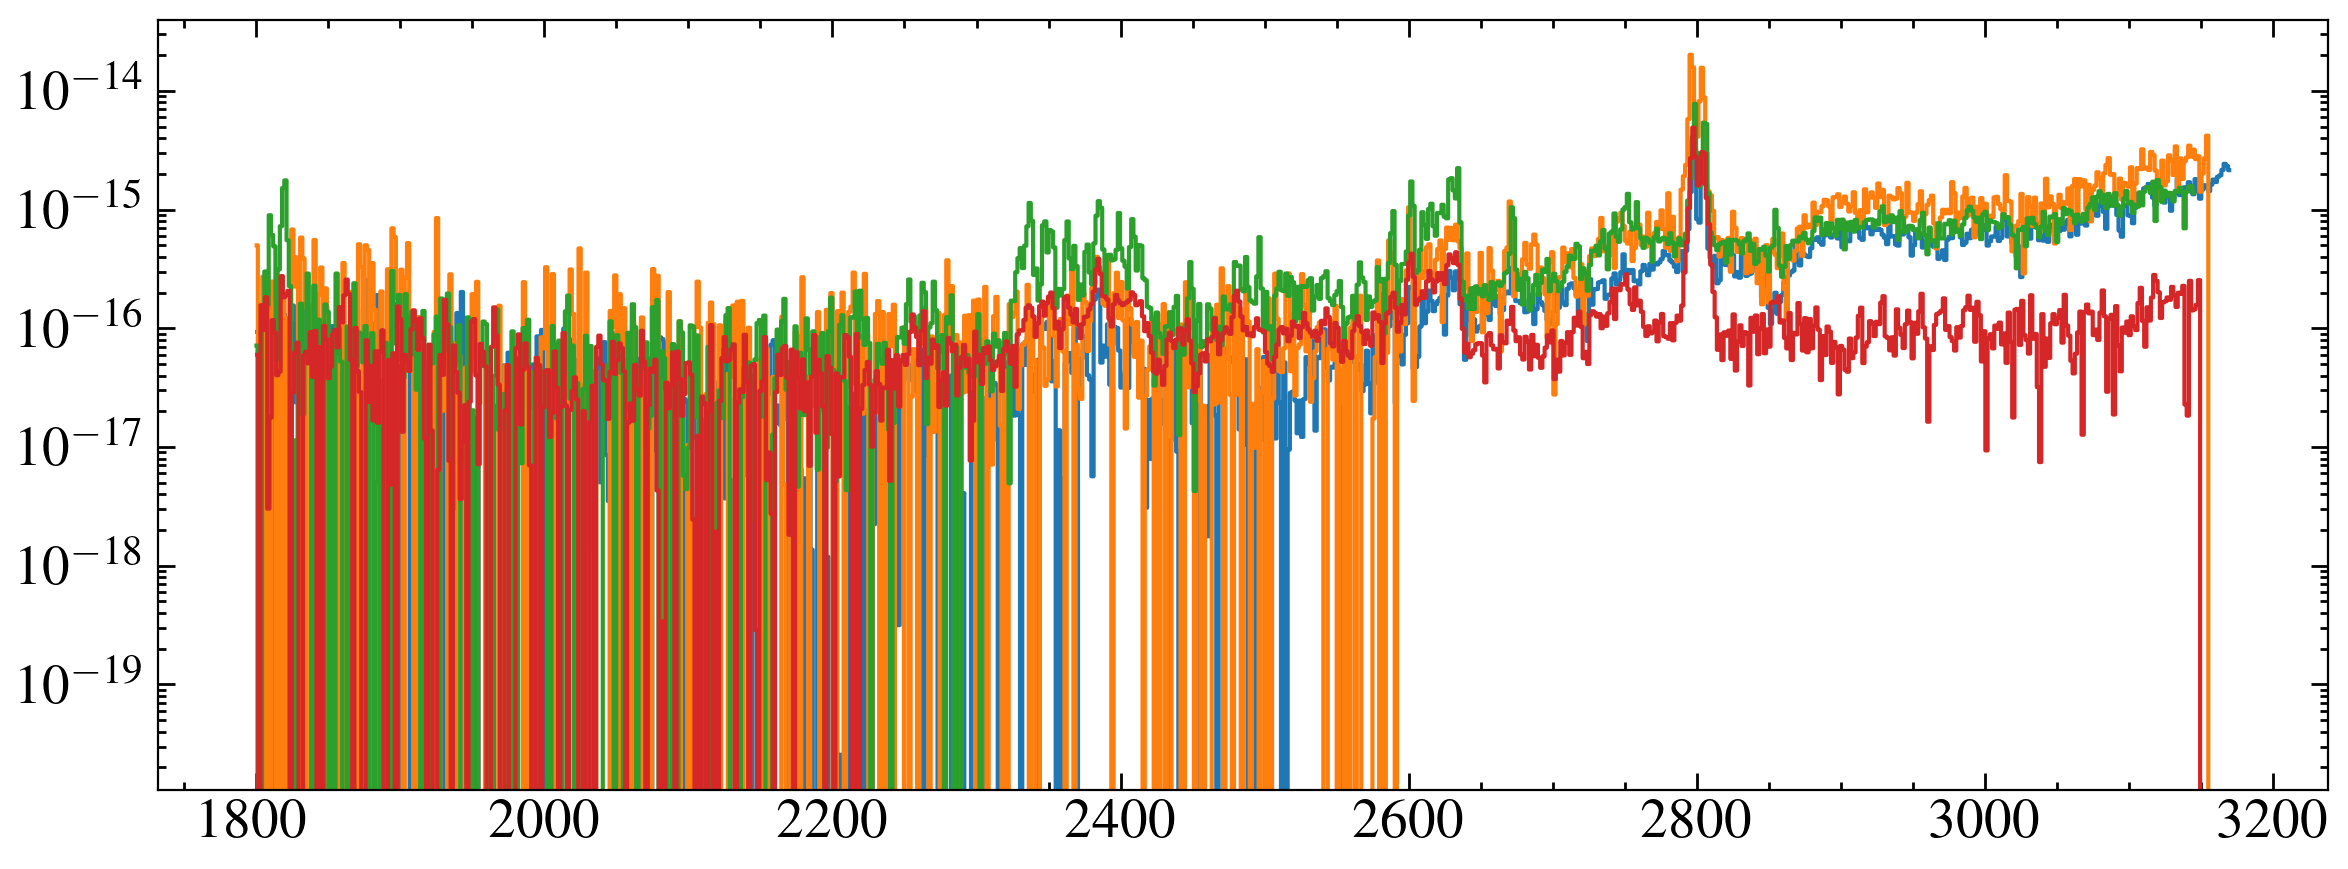

In [38]:
nuvspecs = [ '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj581_g230l_v22_component-spec.fits',
           '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj699_g230l_v23_component-spec.fits',
           '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_gj876_g230l_v22_component-spec.fits',
           '/media/david/2tb_ext_hd/hddata/mega_muscles/nuv_specs/lates/hlsp_muscles_hst_stis_lhs-2686_g230l_v23_component-spec.fits']

for spec in nuvspecs:
    print(spec)
    data = fits.getdata(spec, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1800
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    # plt.step(w, e, where='mid', alpha =0.2)
    plt.yscale('log')
    # plt.show()
  
    
   

Bit terrible, do the simple fitting first

In [39]:
mpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/TRAPPIST-1/'
# w, f = np.loadtxt('t1uv_model_v2.dat', unpack=True)
nuv = fits.getdata('{}hlsp_muscles_hst_cos_trappist-1_g230l_v24_component-spec.fits'.format(mpath), 1)
phx = fits.getdata('{}hlsp_muscles_model_phx_trappist-1_na_v24_component-spec.fits'.format(mpath), 1)
norm = fits.getheader('{}hlsp_muscles_model_phx_trappist-1_na_v24_component-spec.fits'.format(mpath), 0)['NORMFAC']
pw, pf = phx['WAVELENGTH'], phx['FLUX']*norm

4.7625748853059357e-17 4.687123024201185e-18 3.29753147097535e-18 3.291278334269941e-18 2.0041570552963399e-19 1.866306096537357e-19
4.709977014621346e-17 4.5316798905666145e-18 3.282795214017994e-18 4.114500703837729e-18 1.9679684412744362e-19 1.855241119922278e-19
3.742078227266277e-17 3.822203597025791e-18 2.8488357373977445e-18 3.231238607826323e-18 2.375734881995256e-19 1.643265608372743e-19


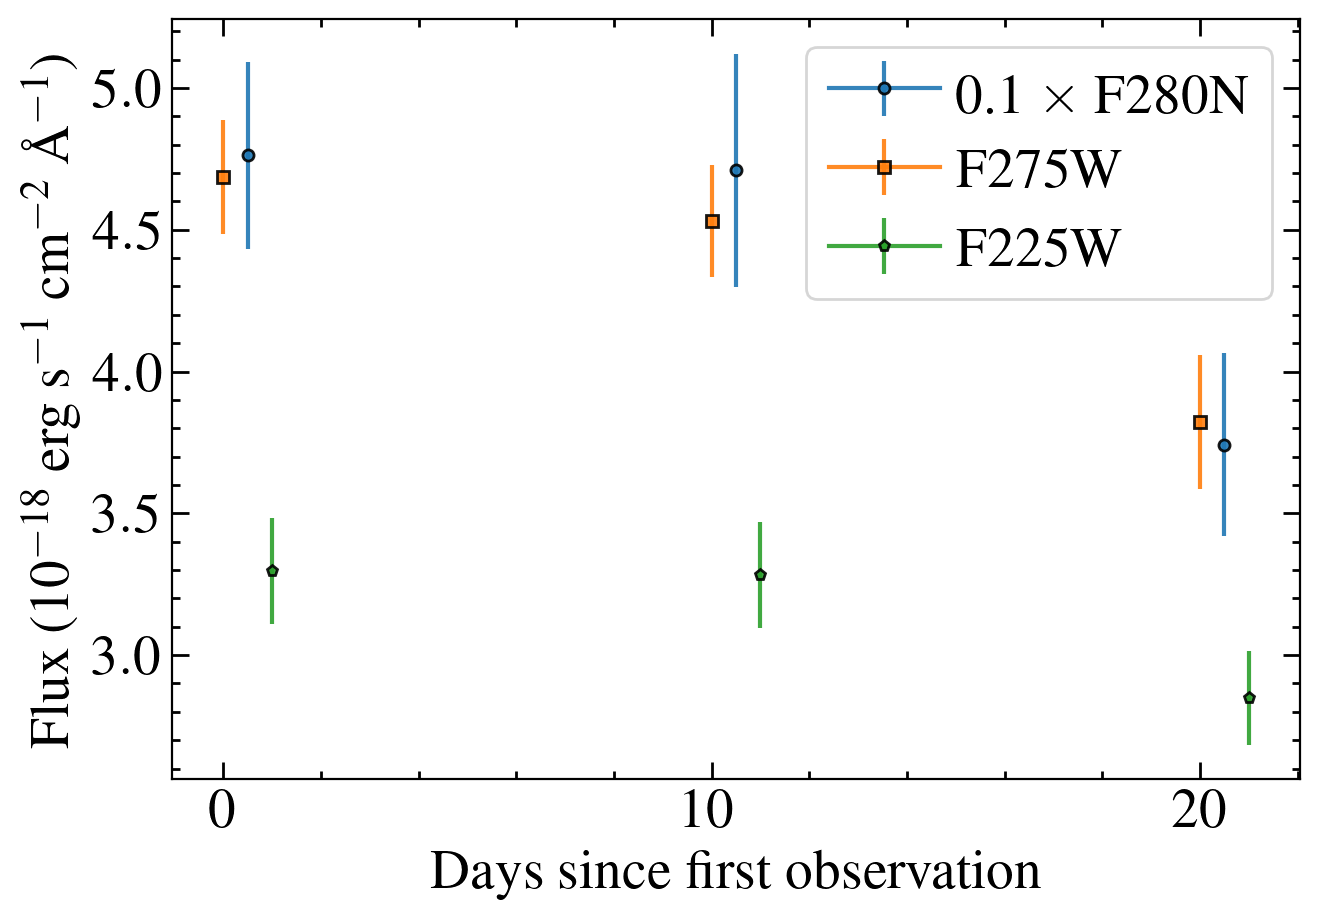

In [40]:
wfc3 = glob.glob('results/*wfc3_p*')
wfc3.sort()
# wfc3
crs = ['if3i03z2q', 'if3i03zcq']

phot_w = np.array([2358.7, 2713.86, 2796.94])

fig, ax = plt.subplots(figsize=(7, 5))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

# cols = [0, 1, 2]

f280n_avs = []
f280n_aves = []
f275w_avs = []
f275w_aves = []
f225w_avs = []
f225w_aves = []



for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    
    f280n = []
    f275w = []
    f225w= []
    f280n_e = []
    f275w_e = []
    f225w_e= []
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                f280n_e.append(row['ERROR'])
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                f275w_e.append(row['ERROR'])
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                f225w_e.append(row['ERROR'])

    f280n ,f275w, f225w,f280n_e, f275w_e, f225w_e = np.array(f280n) ,np.array(f275w), np.array(f225w),np.array(f280n_e), np.array(f275w_e), np.array(f225w_e)
    
    if i == 0:
        f225w, f225w_e = f225w[:-1], f225w_e[:-1] #exclude outliers
        
    if i == 2:
        f275w, f275w_e = f275w[1:], f275w_e[1:] #exclude outliers
    
    f280n_av = np.average(f280n, weights = 1/(f280n_e**2))
    f280n_ave = (1/(np.sum(1/(f280n_e**2))))**0.5
    ax.errorbar(days[i]+0.5, f280n_av*scale/10, yerr=f280n_ave*scale/10, marker='o', c='C0', label = r'0.1 $\times$ F280N',  markeredgecolor='k', markersize=4, alpha=0.9)
        
#     if i == 2:
#         f275w_av = np.average(f275w[1:], weights = 1/(f275w_e[1:]**2))
#         f275w_ave = (1/(np.sum(1/(f275w_e[1:]**2))))**0.5
    
#     else:
    f275w_av = np.average(f275w, weights = 1/(f275w_e**2))
    f275w_ave = (1/(np.sum(1/(f275w_e**2))))**0.5
    ax.errorbar(days[i], f275w_av*scale, yerr=f275w_ave*scale, marker='s', c='C1', label='F275W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    f225w_av = np.average(f225w, weights = 1/(f225w_e**2))
    f225w_e = np.full(len(f225w), f225w_e[0])
    f225w_ave = (1/(np.sum(1/(f225w_e**2))))**0.5
    ax.errorbar(days[i]+1, f225w_av*scale, yerr=f225w_ave*scale, marker='p', c='C2', label = 'F225W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    print(f280n_av ,f275w_av, f225w_av,f280n_ave, f275w_ave, f225w_ave)
    
    f280n_avs.append(f280n_av)
    f280n_aves.append(f280n_ave)
    f275w_avs.append(f275w_av)
    f275w_aves.append(f275w_ave)
    f225w_avs.append(f225w_av)
    f225w_aves.append(f225w_ave)
    
#     print(f280n_av/f275w_av)
#     print(f280n_av/f225w_av)

            
        
            
#         if row['FILTER'] == 'F280N':
#             ax.errorbar(days[i], row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
#                         marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         else:
#             ax.errorbar(days[i], row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)




# ax.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.5, c='C0')
# ax.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.5, c='C1')
# ax.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.5, c='C2')
        
# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since first observation')
ax.set_xticks(days)

# ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

fig.tight_layout()
# fig.savefig('plots/wfc3_average_visits.pdf')

In [41]:
from astropy.modeling.models import custom_model

['filters/HST_WFC3_UVIS2.F225W.dat', 'filters/HST_WFC3_UVIS2.F275W.dat', 'filters/HST_WFC3_UVIS2.F280N.dat']
1990.0 3477.0
2150.676514 3250.0
2751.513428 2887.0


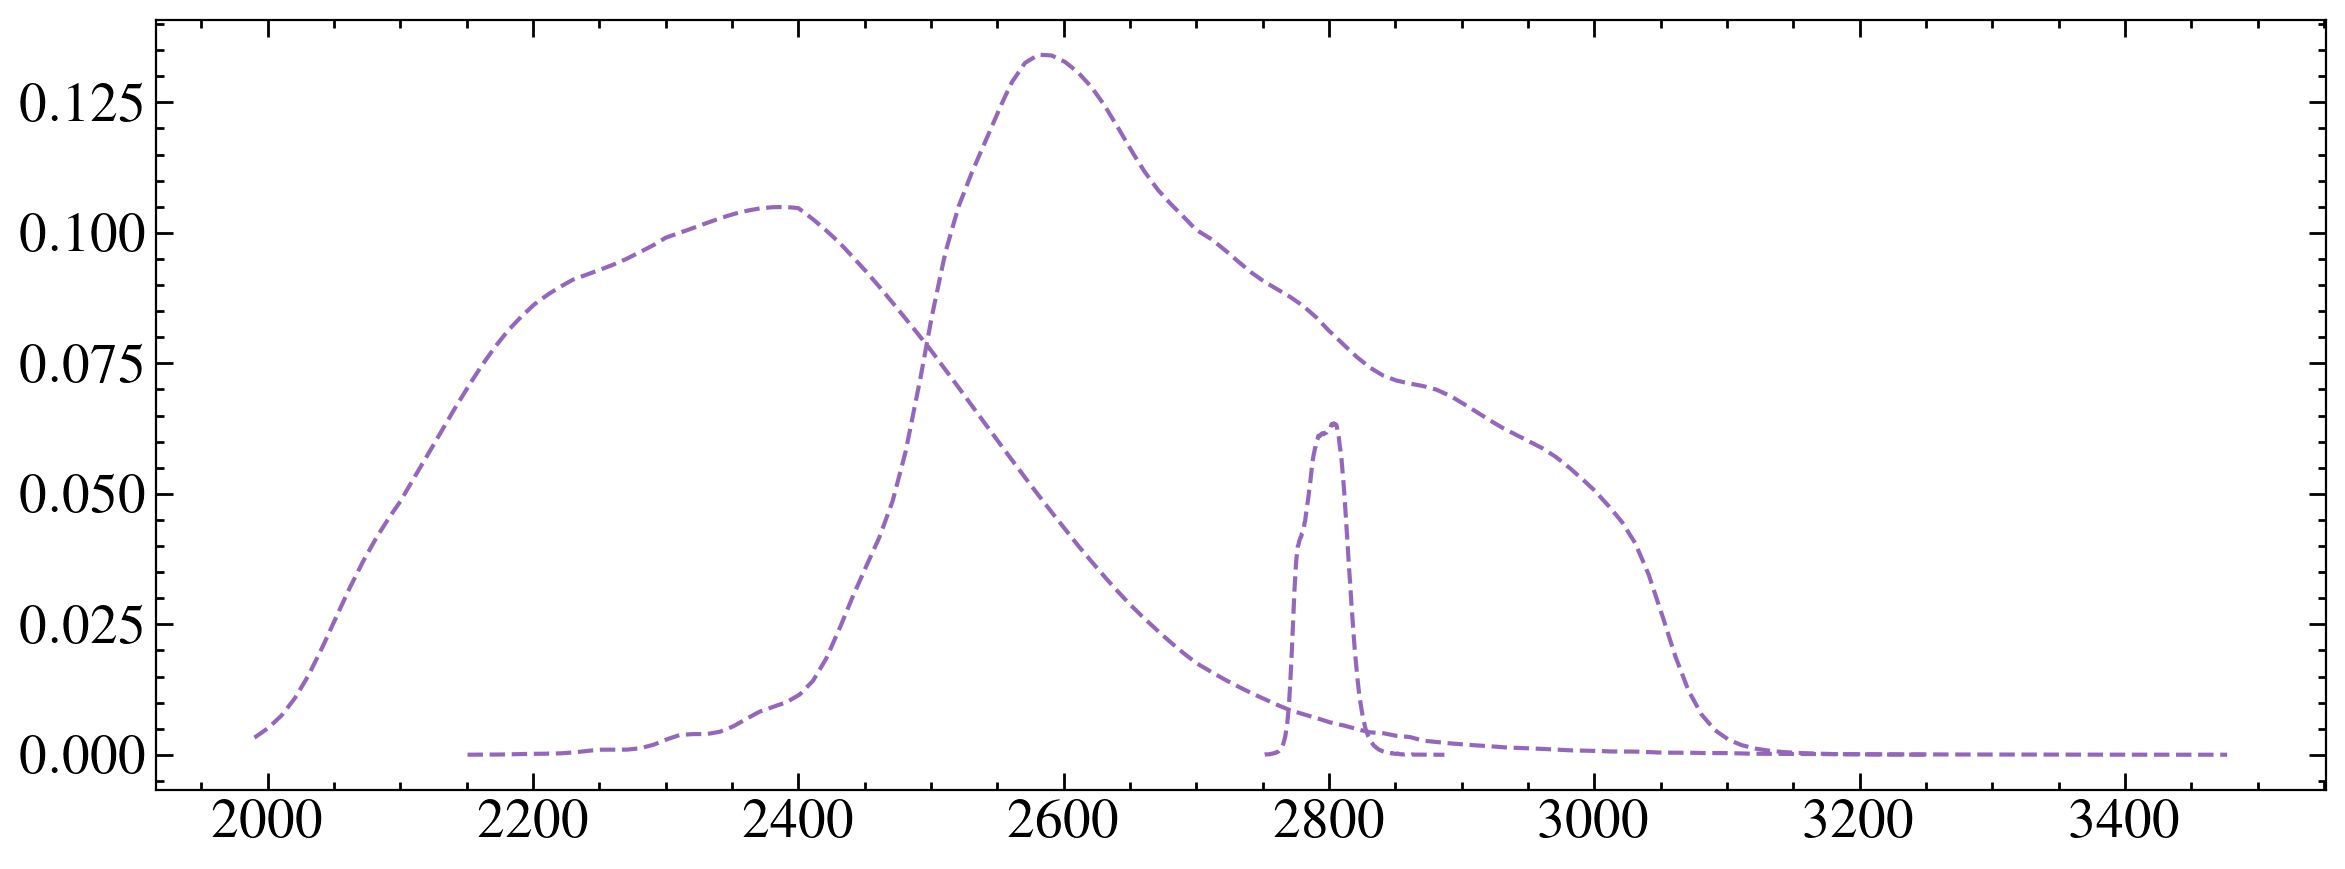

In [42]:
bpws = []
bpfs = []

wbands= glob.glob('filters/*UVIS*')
wbands.sort()
print(wbands)
for band in wbands:
    bpw, bpf = np.loadtxt(band, unpack=True)
    plt.plot(bpw, bpf, ls ='--', c='C4', label = 'Transmission Profiles')
    bpws.append(bpw)
    bpfs.append(bpf)
    print(bpw[0], bpw[-1])

# print(bpws)

4.4465278735456096e-17 1.6791843102408085e-17


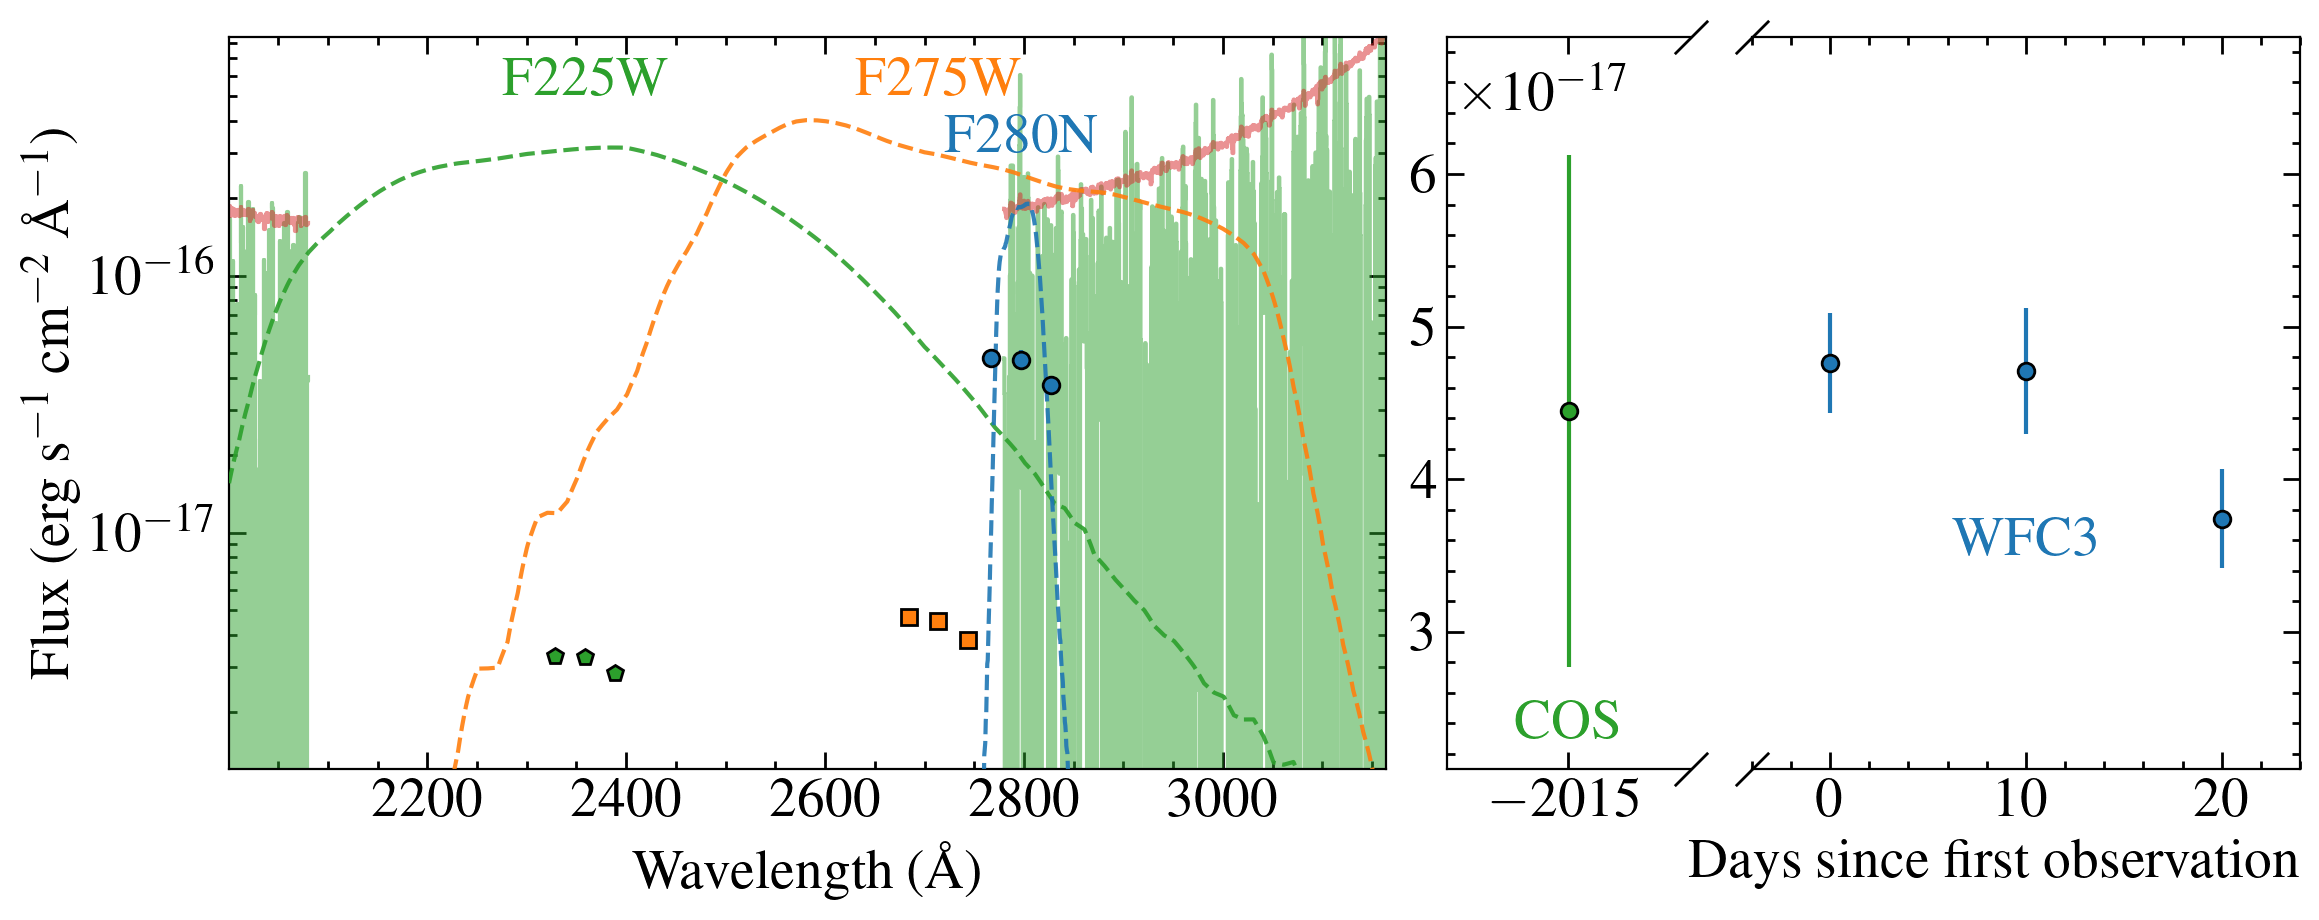

In [43]:

def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 
    # ax.step(nw, nf, where='mid', alpha=0.5)
hasp_path = '/media/david/2tb_ext_hd/hddata/mega_muscles/data/trappist-1/hasp/'
nuv = fits.getdata('{}/hst_15071_cos_2mass-j23062928-0502285_cg230l_ldlm_cspec.fits'.format(hasp_path), 1)[0]
nw, nf, ne = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']


nphot, nphot_e = make_phot(bpws[2], bpfs[2], nw, nf, ne)
print(nphot, nphot_e)

# plt.hist(nphots)
# fig, ax = plt.subplots(figsize=(8, 5))
fig, axes = plt.subplot_mosaic([[0, 0, 0, 0, 1, 2,2]], figsize=(12, 5))
ax = axes[0]
# ax2= ax.twinx()
for j, band in enumerate(wbands):
    bpw, bpf = np.loadtxt(band, unpack=True)
    # ax2.plot(bpw, bpf, ls ='--', c='C4', label = 'Transmission Profiles', zorder=-10, alpha=0.9)
    ax.plot(bpw, bpf*0.3e-14, ls ='--', c='C{}'.format(2-j), label = 'Transmission Profiles', zorder=5, alpha=0.9)
markers = np.array(['p', 's', 'o'])
for i in range(3):

    # rsums = []
    minrsum = 1e9
    best_amp = 0
    best_scale = 0
    # fig, ax = plt.subplots()
    # ax2= ax.twinx()
    
    # fig, ax = plt.subplot_mosaic([[0, 0, 0],[0,0,0], [1,1,1], [2,2,2], [2,2,2], [3,3,3]], sharex=True, figsize=(12, 10))
    phot_w = np.array([2358.7, 2713.86, 2796.94])
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])


    
    for j in range(3):
        # ax.errorbar(phot_w+((i-1)*30), phot_f, yerr=phot_e, marker=marker, ls='none', markeredgecolor='k', label = 'WFC3', zorder=12)
        ax.errorbar(phot_w[j]+((i-1)*30), phot_f[j], yerr=phot_e[j], marker=markers[j], ls='none', markeredgecolor='k', label = 'WFC3', zorder=12, c='C{}'.format(2-j))
    # ax.errorbar(phot_w[2], nphot, yerr =nphot_e, marker='s',  markeredgecolor='k')

    # ax.step(nw, nf, where='mid', alpha=0.5)
    # ax2.plot(bpws[2], bpfs[2])
    # ax.set_ylim(-0.1e-15, 1e-15)
    # ax.set_xlim(2600, 3000)
    # ax.set_yscale('log')


nf = convolve(nf, Box1DKernel(3))
ne = convolve(ne, Box1DKernel(3))
nmask = (nw < 2200)
ax.step(nw[(nw < 2080)], nf[(nw < 2080)], where='mid', alpha=0.5, c='C2')
ax.step(nw[(nw < 2080)], ne[(nw < 2080)], where='mid', alpha=0.5, c='C3')
ax.step(nw[(nw > 2780)], nf[(nw > 2780)], where='mid', alpha=0.5, c='C2')
ax.step(nw[(nw > 2780)], ne[(nw > 2780)], where='mid', alpha=0.5, c='C3')

fnames = ['F225W', 'F275W', 'F280N']
namey = [5e-16, 5e-16, 3e-16] 
[ax.annotate(name, (wi, ny), ha='center', color ='C{}'.format(2-j)) for name, wi, ny, j in zip(fnames, phot_w, namey, range(3))]

# ax.set_ylim(-0.1e-15, 0.9e-15)
ax.set_ylim(1.2e-18, 0.85e-15)
ax.set_yscale('log')
# ax.set_xlim(nw[0]+10, nw[-1]-10)
ax.set_xlim(2001, nw[-1]-10)
# ax2.set_ylim(0.01, 0.136)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')
# ax2.set_ylabel('Transmission')



axes[1].spines.right.set_visible(False)

axes[1].yaxis.tick_left()
axes[2].spines.left.set_visible(False)
axes[2].yaxis.tick_right()
axes[2].yaxis.set_tick_params(labelright=False)

# axes[2].yaxis.tick_left()
d = 1.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axes[1].plot([1, 1], [0, 1], transform=axes[1].transAxes, **kwargs)
axes[2].plot([0, 0], [0, 1], transform=axes[2].transAxes, **kwargs)

mjd_cos = 58102
mjd_e1 = 60116

axes[1].errorbar(mjd_cos- mjd_e1, nphot, yerr= nphot_e, marker='o', ls ='none', markeredgecolor='k', c='C2')
axes[2].errorbar(days, f280n_avs, yerr= f280n_aves, marker='o', ls='none', markeredgecolor='k')

ys = [2.1e-17,6.9e-17]
axes[1].set_ylim(ys)
axes[2].set_ylim(ys)
# axes[1].set_xlim(-2019, -2011)
axes[2].set_xlim(-4, 24)
axes[1].set_xticks([-2015])

# ax[1,0].yaxis.tick_left()
# ax[2,0].yaxis.tick_left()
# ax[3,0].yaxis.tick_left()
# ax[4,0].yaxis.tick_left()
axes[2].set_xlabel('Days since first observation', loc='right')
axes[1].annotate('COS', (-2014, 2.3e-17), xycoords='data', ha='center', color='C2')
axes[2].annotate('WFC3', (10, 3.5e-17), xycoords='data', ha='center', color='C0')
# axes[2].annotate('F280N', (0.95, 0.95), xycoords='axes fraction', ha='right', va='top')


axes[1].yaxis.offsetText.set_visible(False)
axes[1].annotate(r'$\times10^{-17}$', (0.07, 0.96), xycoords='axes fraction', ha='left', va='top')


fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

fig.savefig('plots/wfc3_v_cos.pdf')

In [44]:
# offset

In [45]:
# mg2 = [2796.352, 2803.53]
# os = [6.08e-01, 3.03e-01]

# def make_phot(bp_w, bp_cc, w, f):
#     mask = (w >= bp_w[0]) & (w <= bp_w[-1])
#     w, f = w[mask], f[mask]
#     bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
#     return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

# def tiedamp(mod):
#     amplitude = mod.amplitude_0.value/(os[0]/os[1])
#     return amplitude

# def nuv_phot_model(amp_in, scale_in, bpws, bpfs):
#     mg_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True))
    
  
#     mg_mod.amplitude_1.tied = tiedamp
        
#     bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True, scale=True))
    

    
#     # nuv_mod = mg_mod+bb_mod
#     mod_w = np.linspace(1900, 3500, 100000)*u.AA


#     bb_mod = bb_mod(mod_w).value
#     mg_mod = mg_mod(mod_w).value
#     mod_w = mod_w.value

#     mod_spec = bb_mod + mg_mod
    
#     # mod_spec = nuv_mod(mod_w)
    
#     mod_phots = []
#     for bpw, bpf in zip(bpws, bpfs):
#         phot = make_phot(bpw, bpf, mod_w, mod_spec)
#         mod_phots.append(phot)

#     return(mod_phots, mod_w, mod_spec)






# phx_phot = []
# for bpw, bpf in zip(bpws, bpfs):
#     phot = make_phot(bpw, bpf, pw, pf)
#     phx_phot.append(phot)

# for i in range(1):

#     # rsums = []
#     minrsum = 1e9
#     best_amp = 0
#     best_scale = 0
#     fix, ax = plt.subplots()
#     # fig, ax = plt.subplot_mosaic([[0, 0, 0],[0,0,0], [1,1,1], [2,2,2], [2,2,2], [3,3,3]], sharex=True, figsize=(12, 10))
#     phot_w = np.array([2358.7, 2713.86, 2796.94])
#     phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
#     phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])
    
#     ax.errorbar(phot_w+10, phot_f-phx_phot, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'WFC3', zorder=12)
#     ax.set_yscale('log')

#     # guess_mg = np.linspace(2e-16, 12e-16, 10)
#     # guess_mg = np.linspace(0.1e-16, 10e-16, 200)
#     # guess_mg = np.arange(0.1e-16, 10e-16, 0.1e-16)
#     # guess_scale = np.linspace(0.8e-25, 7e-25, 10)
#     # guess_scale = np.linspace(0.1e-25, 4e-25, 200)

#     guess_mg = np.arange(0.1e-16, 10.1e-16, 0.05e-16)
# # print(len(guess_mg))
#     guess_scale = np.arange(0.1e-25, 5.1e-25, 0.025e-25)
#     # guess_scale = np.arange(0.1e-25, 10.1e-25, 0.05e-25)
# # print(len(guess_scale))

#     rsums_all = []
#     rsums_all_log = []

#     for j in guess_mg:
#         rsums = []
#         rsums_log = []
#         for k in guess_scale:
            

#             mod_phots, mod_w, mod_f = nuv_phot_model(j, k , bpws, bpfs)
    
#             # ax.plot(mod_w, mod_f, alpha=0.3)
#             ax.errorbar(phot_w, mod_phots, marker='x', ls='none', label = 'WFC3', zorder=11)

#             # chisquare(phot_f, f_exp=mod_phots, ddof=2, axis=0)
#             rsum = np.sum((((phot_f-phx_phot) - mod_phots)/phot_e)**2)
#             rsum_log = np.sum((np.log(phot_f-phx_phot) - np.log(mod_phots))**2)
            
            
#       #       rsum = redchisqg(phot_f-phx_phot,mod_phots,deg=2,sd=phot_e)
#       #       chisq=numpy.sum( ((ydata-ymod)/sd)**2 )  
             
#       # # Number of degrees of freedom assuming 2 free parameters  
#       # nu=ydata.size-1-deg  
        
#             # print(rsum)
#             if rsum < minrsum:
#                 minrsum = rsum
#                 best_amp = j
#                 best_scale = k
#             rsums.append(rsum)
#             rsums_log.append(rsum_log)
#         rsums_all.append(rsums)
#         rsums_all_log.append(rsums_log)

    
#     mod_phots, mod_w, mod_f = nuv_phot_model(best_amp, best_scale , bpws, bpfs)
#     ax.errorbar(phot_w, mod_phots, marker='s', ls='none', label = 'WFC3', zorder=13, markeredgecolor='k')
#     print(best_amp, best_scale, minrsum)


   

#     # ax.plot()

#     # ax[0].plot(w, f, zorder=-1, c='C1', alpha=0.5)

#     # ax[0].step(wn, fn, alpha =0.5, where='mid', zorder=-2, c='C4', label='COS')



#     # ax[0].errorbar(phot_w, mod_phot, marker='s', ls='none', zorder=11, c='C1', markeredgecolor='k', label ='PHX')

#    # 5.737373737373737e-16 1.98989898989899e-25

In [46]:
# fitter= fitting.LevMarLSQFitter()


# # plt.contourf([guess_mg, guess_scale], rsums)
# fig, ax = plt.subplots()
# im = ax.imshow(1/np.array(rsums_all_log), origin='lower')
# ax.contour(rsums_all)

# cb = fig.colorbar(im, ax=ax)
# # print(rsums_all)

# # print(np.median(rsums_all), np.mean(rsums_all), np.std(rsums_all))
# mod = models.Gaussian2D(amplitude=-20, x_mean =20, y_mean=20)#, bounds = dict(x_mean = [5, 45], y_mean=[5, 45]))
# x, y = np.mgrid[:len(rsums_all), :len(rsums_all)]
# fit = fitter(mod,x,y, 1/np.array(rsums_all_log))
# # fig.colorbar()

# # print(fit)
# print(fit.x_mean.value, fit.y_mean.value, fit.amplitude)#, fit.x_stddev)


# def fit_to_par(guess, coord):
#     return (((max(guess) - min(guess))/len(guess)) * coord) + min(guess)

# mg_fit = fit_to_par(guess_mg, fit.x_mean.value)
# mg_err_up = fit_to_par(guess_mg, fit.x_mean.value+fit.x_stddev.value)
# mg_err_down = fit_to_par(guess_mg, fit.x_mean.value-fit.x_stddev.value)
# mg_err = ((mg_err_up-mg_fit) + (mg_fit-mg_err_down))/2

# scale_fit = fit_to_par(guess_scale, fit.y_mean.value)
# scale_err_up = fit_to_par(guess_scale, fit.y_mean.value+fit.y_stddev.value)
# scale_err_down = fit_to_par(guess_scale, fit.y_mean.value-fit.y_stddev.value)
# scale_err = ((scale_err_up-scale_fit) + (scale_fit-scale_err_down))/2

# print(mg_fit, mg_err)
# print(scale_fit, scale_err)

# # print(mg_fit, scale_fit)

# # 5.634798344669069e-16 3.22480798243634e-16
# # 1.9930443680276343e-25 6.046596741364057e-26
# # 6.6331843503342195e-16 2.0921708519017021e-16
# # 2.247897302878292e-25 7.019736642939619e-26


In [47]:
# fig, ax = plt.subplots()
# ax.errorbar(phot_w+10, phot_f-phx_phot, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'WFC3', zorder=12)

# # 5.634798344669069e-16 3.22480798243634e-16
# # 1.9930443680276343e-25 6.046596741364057e-26

# mod_phots, mod_w, mod_f = nuv_phot_model(5.6e-16,2e-25  , bpws, bpfs)
# ax.errorbar(phot_w, mod_phots, marker='s', ls='none', label = 'WFC3', zorder=13, markeredgecolor='k')
# ax.plot(mod_w, mod_f)
# mod_phots, mod_w, mod_f = nuv_phot_model(5.6e-16,2e-25  , bpws, bpfs)
# # ax.errorbar(phot_w, mod_phots, marker='s', ls='none', label = 'WFC3', zorder=13, markeredgecolor='k')
# ax.plot(mod_w, mod_f)



Think we need to add another component. Or just use the fit to LHS 2686 as a proxy?

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
    ----------- ---------------------
         8500.0 4.102232513471039e-24


(1251.0, 3151.0)

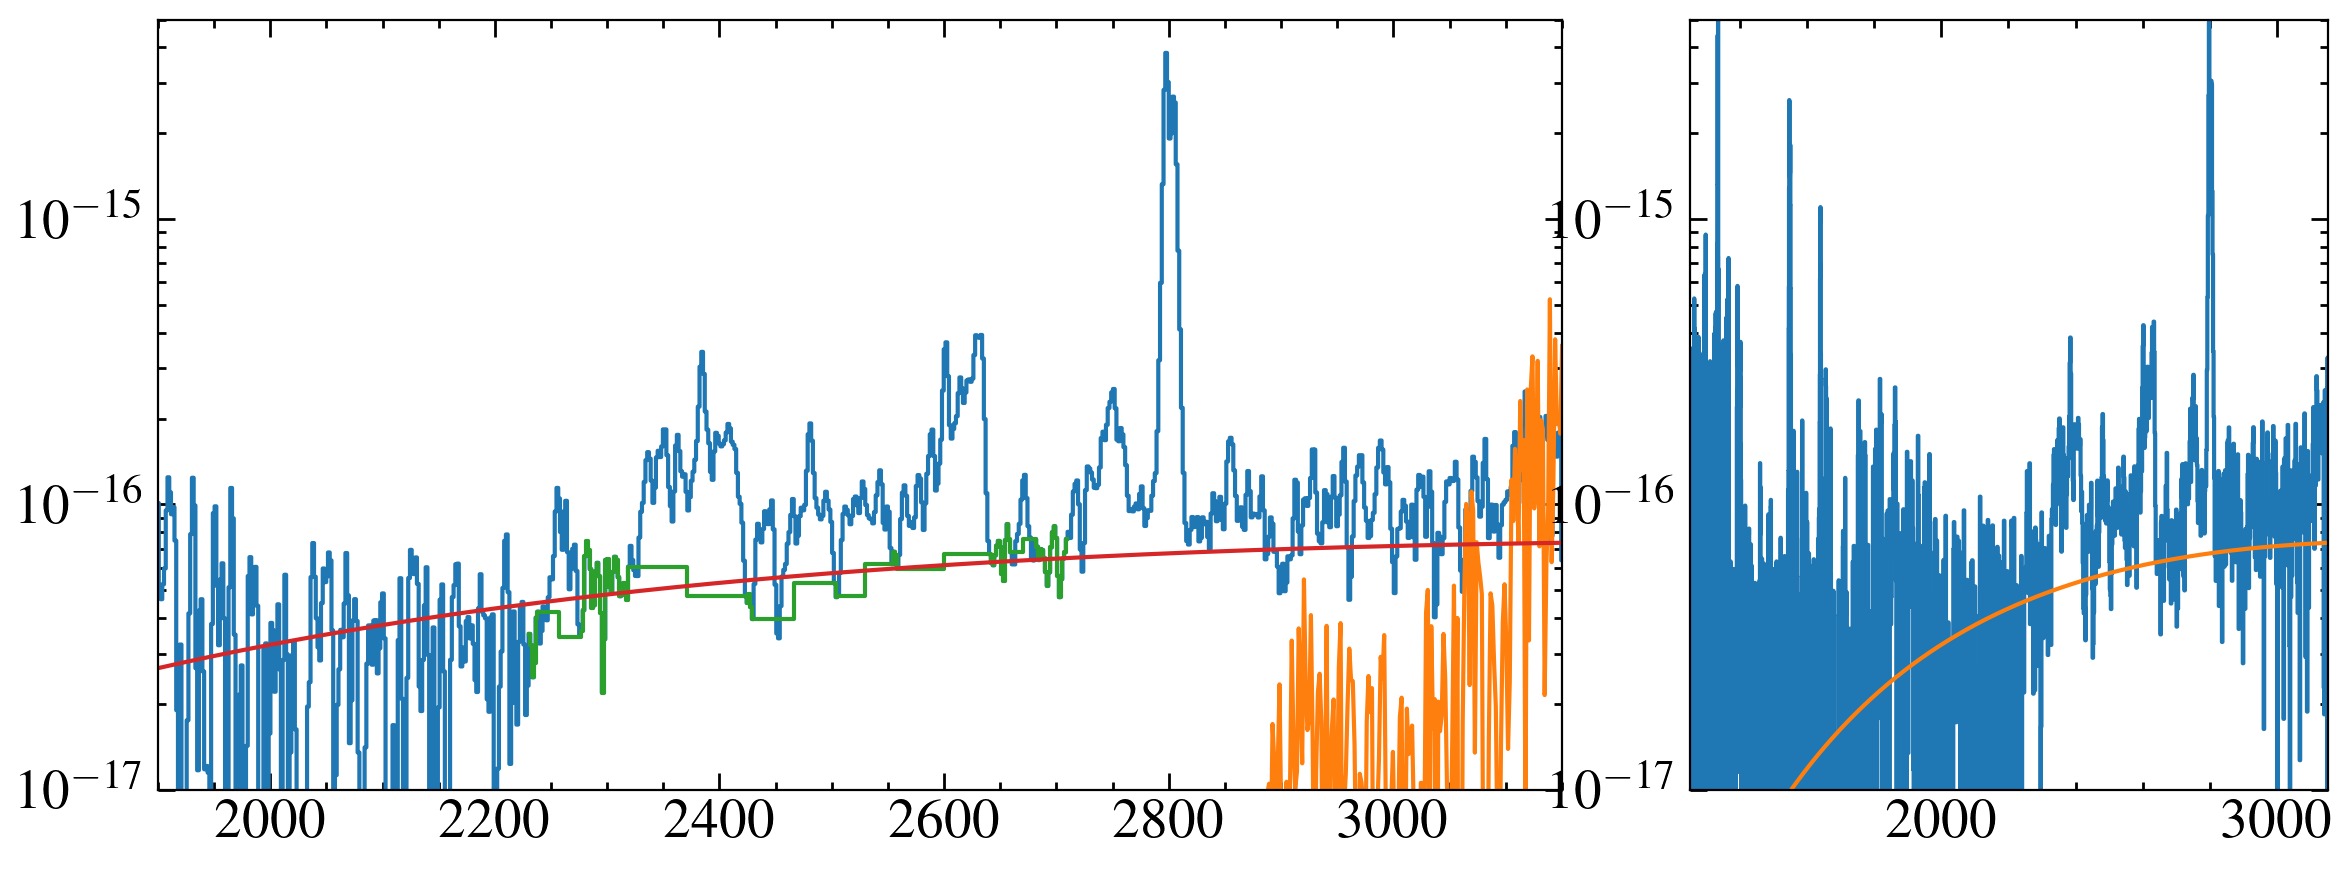

In [48]:
fitter = fitting.LevMarLSQFitter()
# fig, ax = plt.subplots()

fig, ax = plt.subplot_mosaic([[0, 0, 1]])



m6path ='/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/LHS-2686/'
phx = 'hlsp_muscles_model_phx_lhs-2686_na_v24_component-spec.fits'
nuv = 'hlsp_muscles_hst_stis_lhs-2686_g230l_v24_component-spec.fits'
sed = 'hlsp_muscles_multi_multi_lhs-2686_broadband_v24_var-res-sed.fits'
ndata = fits.getdata(m6path+nuv,1)
wn, fn, en = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
smooth = 2
fn = convolve(fn,Box1DKernel(smooth))
en = convolve(en,Box1DKernel(smooth))/(smooth**0.5)

ax[0].step(wn, fn, where='mid')
# ax.step(wn, en, where='mid')

pdata = fits.getdata(m6path+phx,1)
norm = fits.getheader(m6path+phx)['NORMFAC']
wp, fp = pdata['WAVELENGTH'], pdata['FLUX']*norm
# ax.plot(wp, fp, zorder=-1)

pfi = interp1d(wp, fp, fill_value='extrapolate')(wn)
ax[0].plot(wn, pfi)



bb_init = models.BlackBody(temperature=8500*u.K, scale=5e-24*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed =dict(temperature=True) )

# ax.plot(wn, bb_init(wn))

cont_mask = (wn > 2230) & ( wn < 2240) | (wn > 2275) & ( wn < 2320) |  (wn > 2422) & ( wn < 2431) | (wn > 2502) & ( wn < 2507) | (wn > 2553) & ( wn < 2560) | (wn > 2640) & (wn <2660) | (wn > 2680) & (wn < 2710) 
fit_w, fit_f, fit_e = wn[cont_mask], fn[cont_mask], en[cont_mask]

ax[0].step(fit_w, fit_f, where='mid')


bb_fit = fitter(bb_init, fit_w, fit_f, weights = 1/fit_e, maxiter=10000)
print(bb_fit)

ax[0].plot(wn, bb_fit(wn))

ax[0].set_yscale('log')

ax[0].set_xlim(1900, 3150)
ax[0].set_ylim(1e-17, 5e-15)

# final_mod = gg_fit[3](wn) + gg_fit[4](wn)+gg_fit[5](wn)+gg_fit[6](wn)

sdata = fits.getdata(m6path+sed,1)
ws, fs = sdata['WAVELENGTH'], sdata['FLUX']
smask = (ws > 1250) & (ws < 3200) 
ax[1].step(ws[smask], fs[smask], where='mid')

pfi2 = interp1d(wp, fp, fill_value='extrapolate')(ws[smask])

# ax[1].plot(ws[smask], gg_fit(ws[smask])+pfi2)
ax[1].plot(ws[smask], bb_fit(ws[smask]))
# ax[1].plot(ws[smask], bb_fixed_fit(ws[smask])+pfi2)

ax[1].set_yscale('log')
ax[1].set_ylim(1e-17, 5e-15)
ax[1].set_xlim(1251, 3151)

# savdat = Table([wn, final_mod], names=['WAVELENGTH', 'FLUX'])
# savdat.write('model_spectra/lhs2686_nuv_model.ecsv', format='ascii.ecsv', overwrite=True)


# fig.show()

# plt.figure()
# plt.plot(wn[mask], en[mask])
# plt.axhline(np.median(en[mask]))
# # plt.plot(wn, fn/en)
# # plt.ylim(0, 20)


# print(np.trapz(gg_fit(wn[mask]), wn[mask]))
# print(np.trapz(bb_fixed_fit(wn[mask]), wn[mask]))
# print(gg_fit)

[32.88755681 44.49057171 25.509409  ] 34.29584584130566
[25.89989219]
[1.26979512 1.71778984 0.98492337] 1.3241694438374294
[ 0.26979512  0.71778984 -0.01507663] 3.0715613588690426e+17


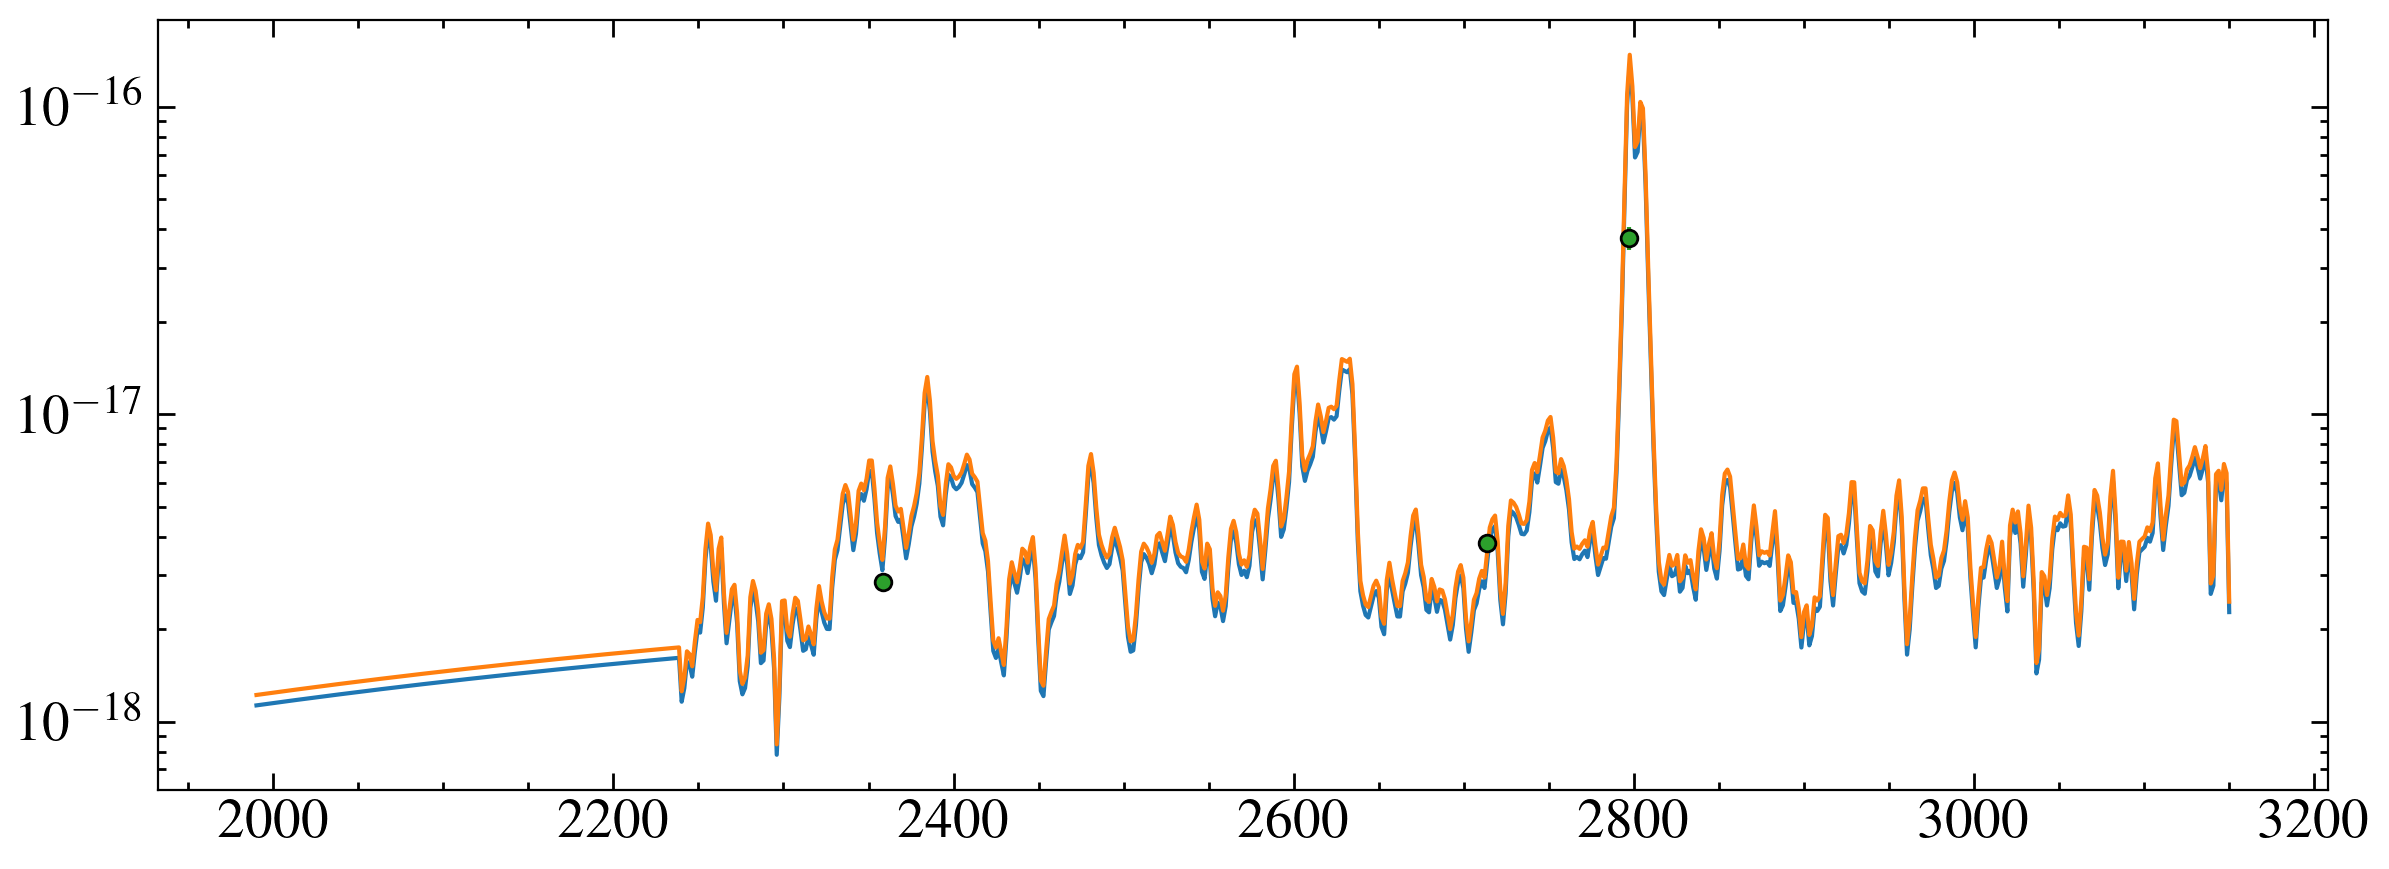

In [49]:
def residuals(scale, f, mf):
    return f - mf/scale

wprox = wn[wn >=1990] 

fprox = np.hstack((bb_fit(wn)[(wn >=1990) & (wn <2240)], fn[(wn >=2240)]))
# fprox = fn[wn >=1990]


fig, ax = plt.subplots()


# mgmod = models.Gaussian1D(10e-16, 2800, 10)
mgmod = models.Box1D(20e-16, 2800, 10)
mgmod = mgmod(wprox)

# ax.plot(wprox, (fprox+mgmod)/30)
ax.plot(wprox, (fprox)/28)


mod_phots = []
for bpw, bpf in zip(bpws, bpfs):
    # phot = make_phot(bpw, bpf, wprox, fprox+mgmod)
    phot = make_phot(bpw, bpf, wprox, fprox)
    mod_phots.append(phot)

scale = leastsq(residuals, 1., args=(phot_f, mod_phots))[0]
# scale = np.mean(mod_phots/phot_f)
print(mod_phots/phot_f, np.mean(mod_phots/phot_f))
print(scale)
ax.plot(wprox, fprox/scale)


mod_phots2 = []
for bpw, bpf in zip(bpws, bpfs):
    # phot = make_phot(bpw, bpf, wprox, fprox+mgmod)
    phot = make_phot(bpw, bpf, wprox, fprox/scale)
    mod_phots2.append(phot)
print(mod_phots2/phot_f, np.mean(mod_phots2/phot_f))
    
print((mod_phots2-phot_f)/phot_f, np.mean((mod_phots2/phot_f)/phot_f))

ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'WFC3', zorder=12)
ax.set_yscale('log')

# ax.plot(mod_w, mod_f)

In [50]:
# import warnings
# import numpy as np
# import matplotlib.pyplot as plt
# from astropy.modeling import models, fitting
# from astropy.utils.exceptions import AstropyUserWarning

# # Generate fake data
# rng = np.random.default_rng(0)
# y, x = np.mgrid[:128, :128]
# z = 2. * x ** 2 - 0.5 * x ** 2 + 1.5 * x * y - 1.
# z += rng.normal(0., 0.1, z.shape) * 50000.

# # Fit the data using astropy.modeling
# p_init = models.Polynomial2D(degree=2)
# fit_p = fitting.LevMarLSQFitter()

# with warnings.catch_warnings():
#     # Ignore model linearity warning from the fitter
#     warnings.filterwarnings('ignore', message='Model is linear in parameters',
#                             category=AstropyUserWarning)
#     p = fit_p(p_init, x, y, z)

# # Plot the data with the best-fit model
# plt.figure(figsize=(8, 2.5))
# plt.subplot(1, 3, 1)
# plt.imshow(z, origin='lower', interpolation='nearest', vmin=-1e4, vmax=5e4)
# plt.title("Data")
# plt.subplot(1, 3, 2)
# plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
#            vmax=5e4)
# plt.title("Model")
# plt.subplot(1, 3, 3)
# plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
#            vmax=5e4)
# plt.title("Residual")

In [51]:
guess_mg = np.arange(0.1e-16, 10.1e-16, 0.05e-16)
print(len(guess_mg))
guess_scale = np.arange(0.1e-25, 5.1e-25, 0.025e-25)
print(len(guess_scale))

200
200


In [52]:
phx_phot = []
for bpw, bpf in zip(bpws, bpfs):
    phot = make_phot(bpw, bpf, pw, pf)
    phx_phot.append(phot)

print(phx_phot)

[2.4373087222784013e-21, 5.160707555264283e-21, 3.230484954608523e-22]


In [97]:
mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]

@custom_model
def nuv_fit(x, amplitude=1e-16, scale=1e-25):
    return nuv_phot_model(amplitude, scale)

def nuv_phot_model(amp_in, scale_in):
    mg_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=(amp_in/(os[0]/os[1]))*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True))
    def tiedamp(mod):
        amplitude = mod.amplitude_0.value/(os[0]/os[1])
        return amplitude
  
    mg_mod.amplitude_1.tied = tiedamp
        
    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))
    

    
    # nuv_mod = mg_mod+bb_mod
    mod_w = np.linspace(1900, 3500, 100000)*u.AA


    bb_mod = bb_mod(mod_w).value
    mg_mod = mg_mod(mod_w).value
    mod_w = mod_w.value

    mod_spec = mg_mod + bb_mod
    
    # mod_spec = nuv_mod(mod_w)

    wbands= glob.glob('filters/*UVIS*')
    wbands.sort()


    
    mod_phots = []
    for band in wbands:
        bpw, bpf = np.loadtxt(band, unpack=True)
        phot = make_phot(bpw, bpf, mod_w, mod_spec)
        mod_phots.append(phot)



    return(np.array(mod_phots))






Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               scale         
    --------------------- ----------------------
    7.638781293208803e-16 1.9917254457999382e-25 [6.39734372e-17 1.24669427e-26]
[2.65404828e-18 5.31213336e-18 3.80530882e-17]
5.689402089922387e-36
Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               scale         
    --------------------- ----------------------
    6.568414968276414e-16 2.0459168790762651e-25 [7.39789810e-17 1.30979111e-26]
[2.69488344e-18 5.08886556e-18 3.32680020e-17]
6.003211647152606e-36
Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               scale         
    --------------------- ----------------------
    5.841014739084463e-16 1.8442737618238748e-25 [6.30455413e-17 1.17317419e-26]
[2.42731453e-18 4.56428593e-18 2.96247443e-17]
4.8781871695776456e-36


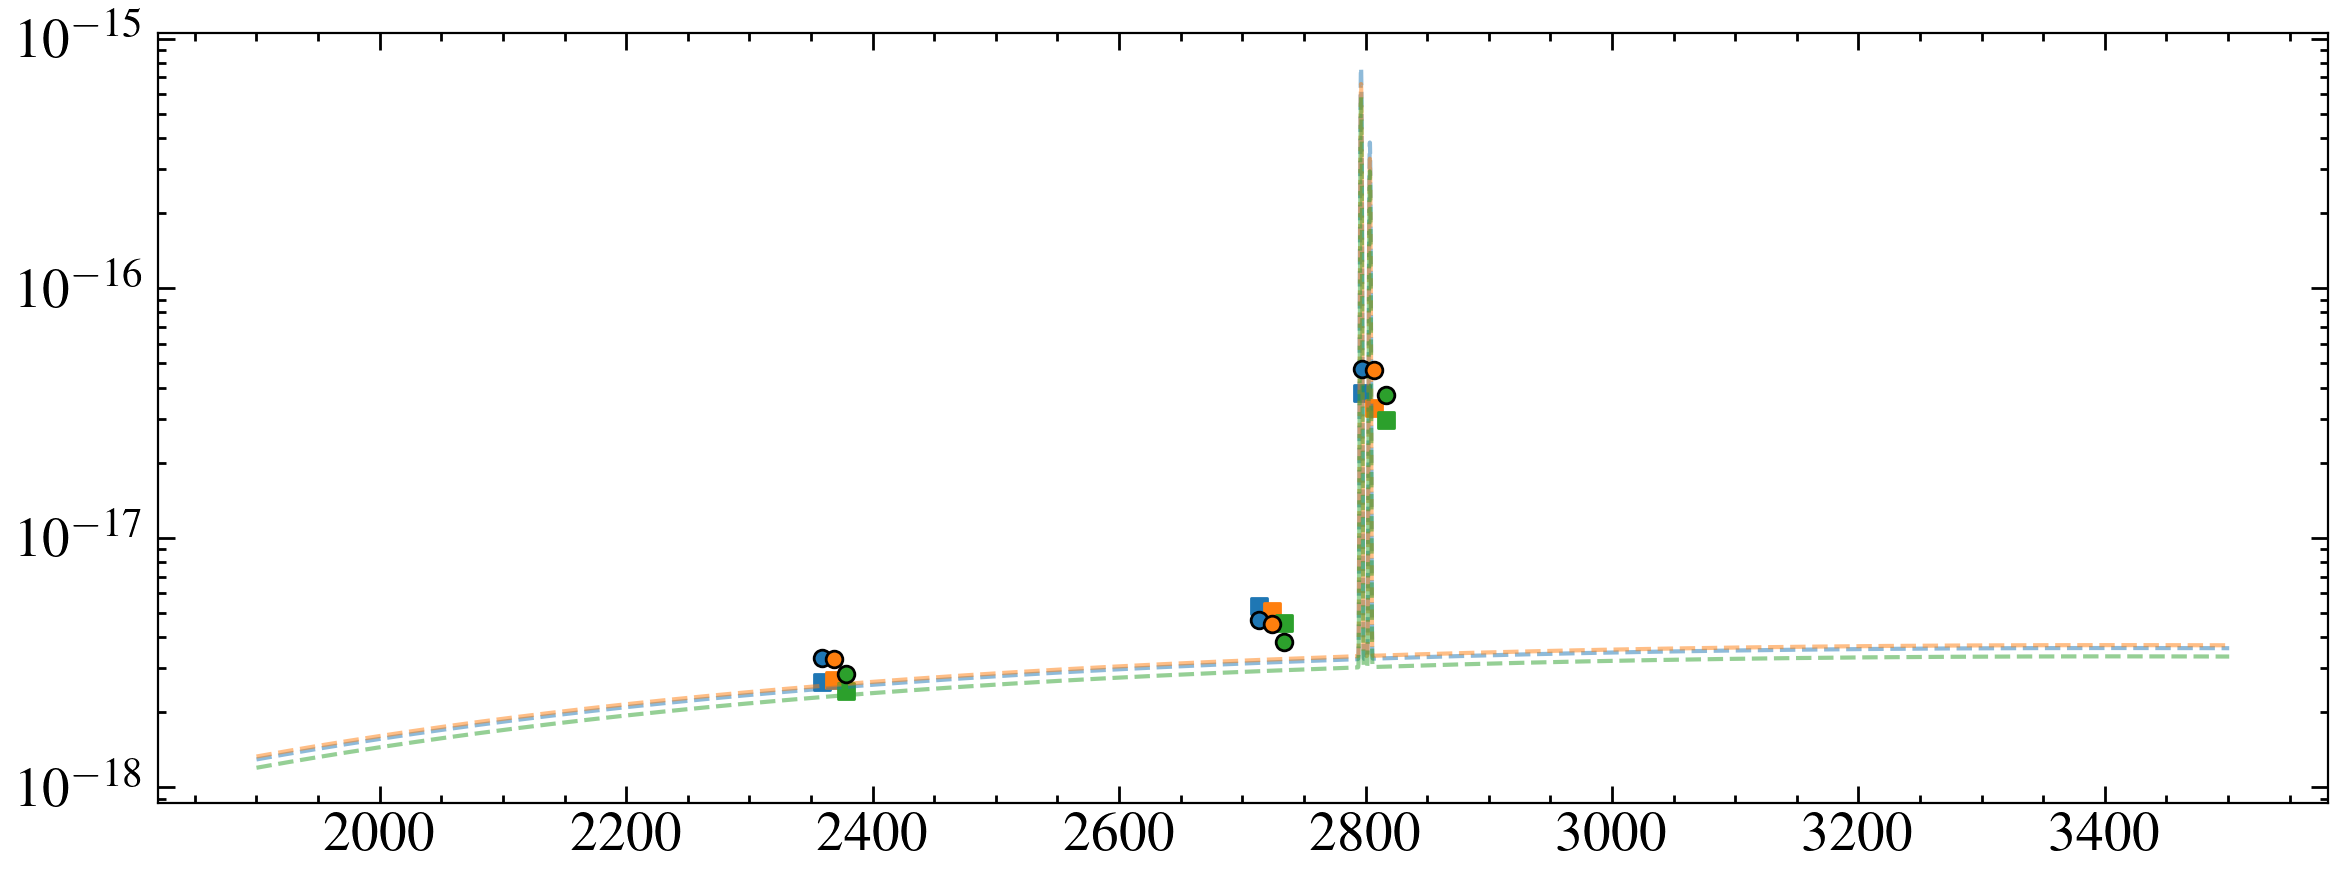

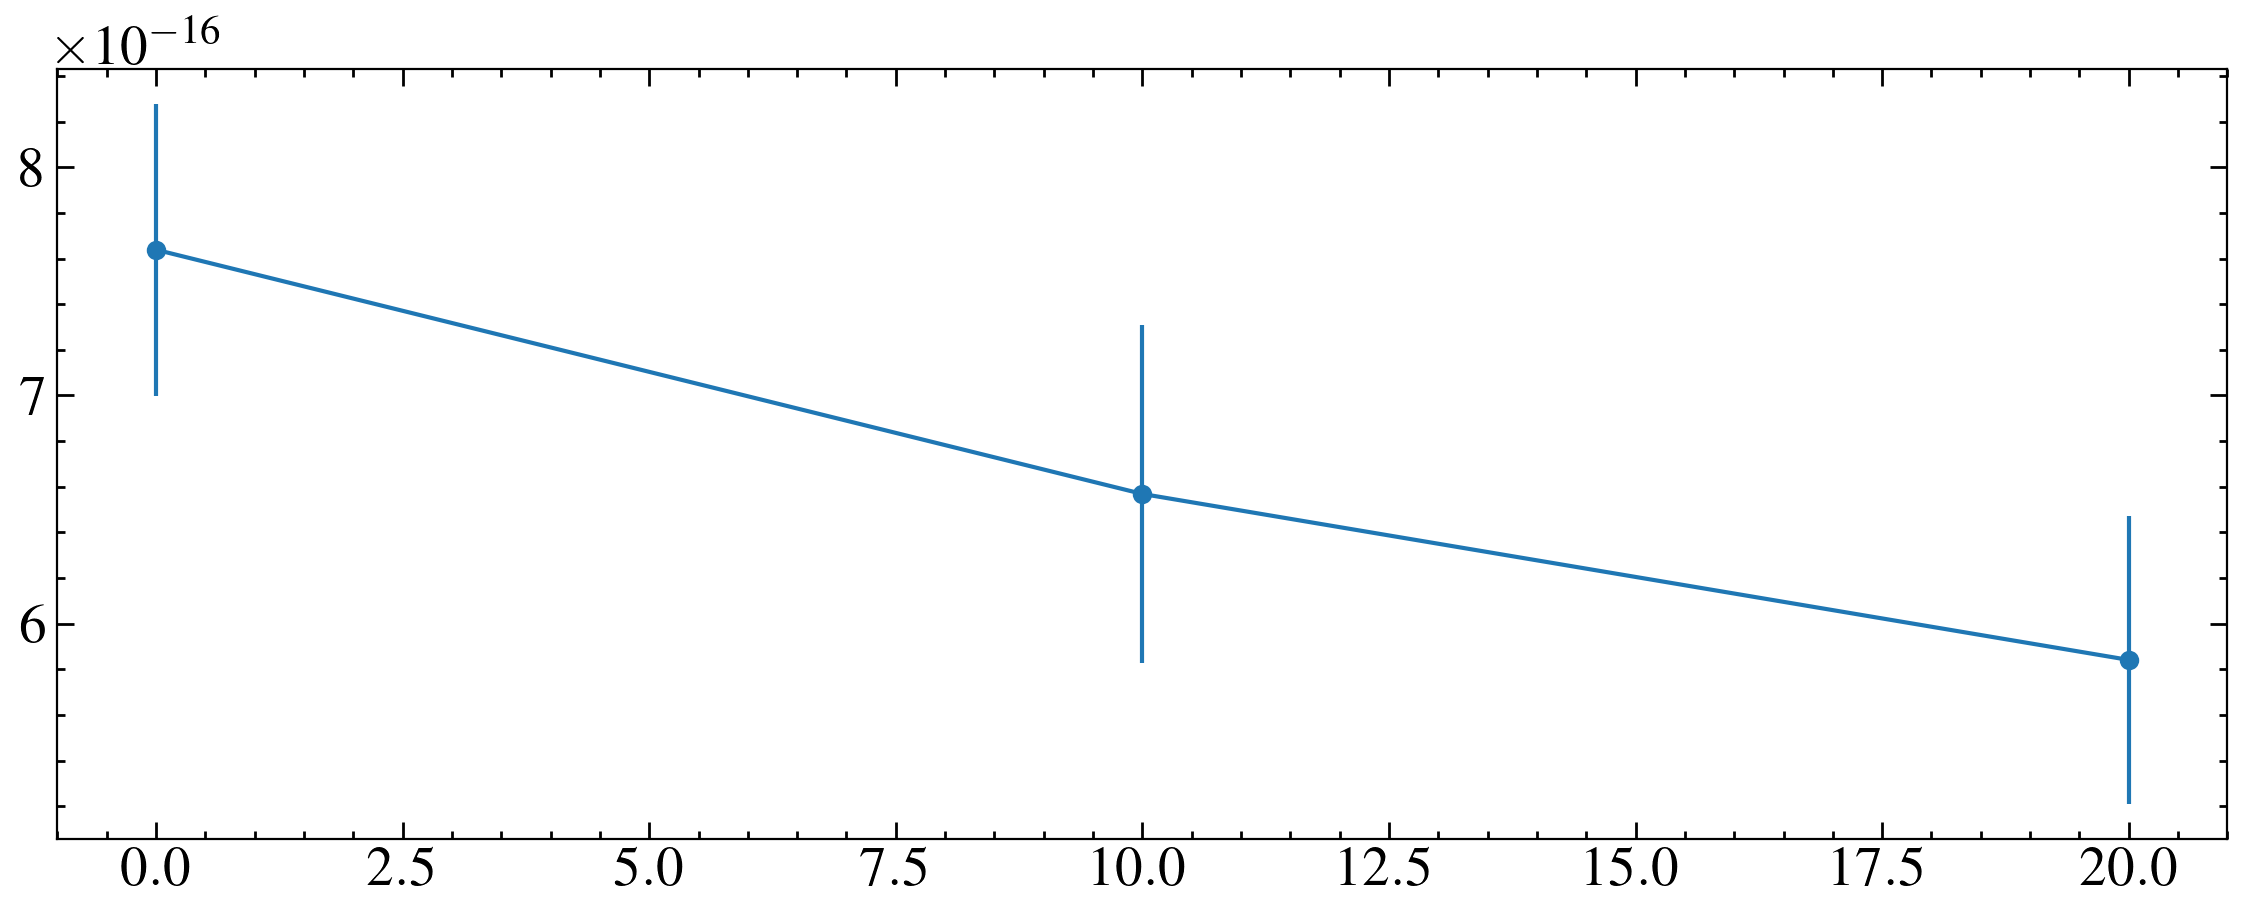

<ErrorbarContainer object of 3 artists>

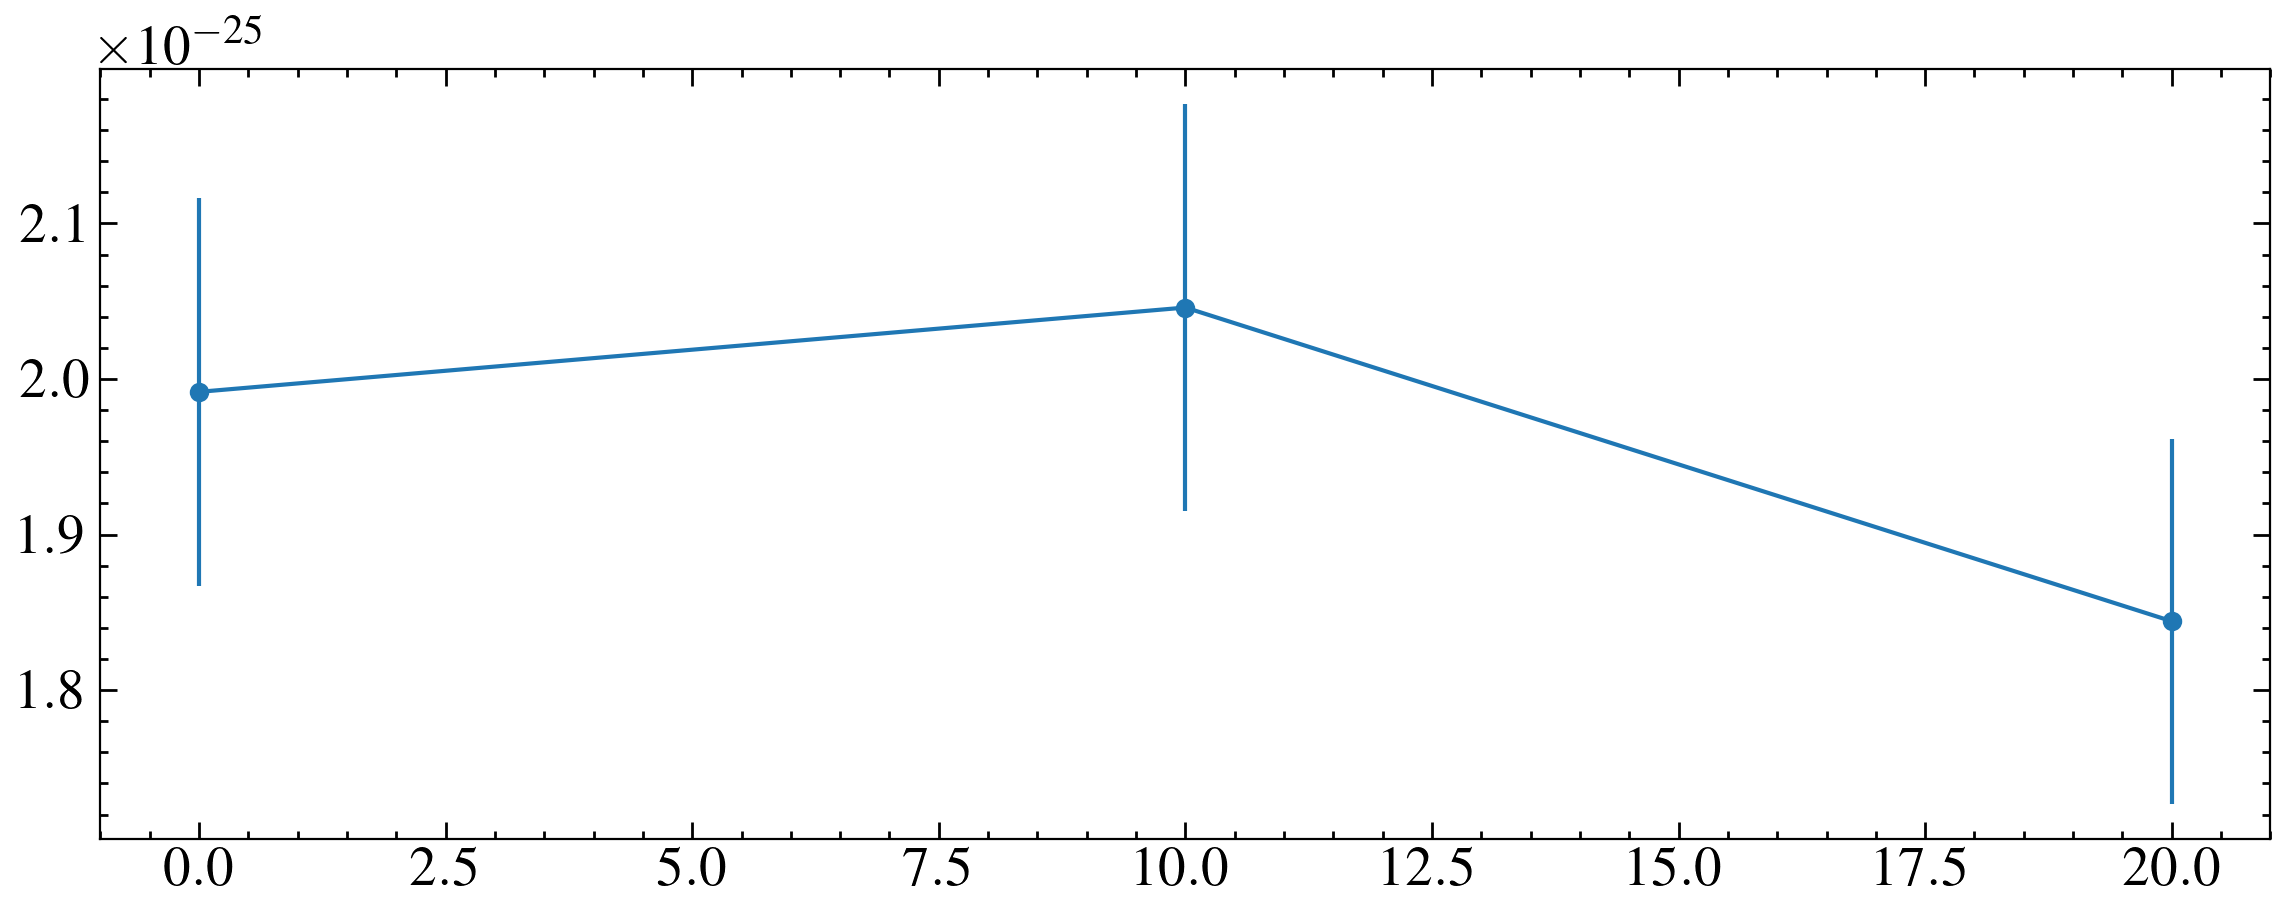

In [98]:
fitter= fitting.LevMarLSQFitter()


def nuv_bb_model(amp_in, scale_in):
    mg_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=(amp_in/(os[0]/os[1]))*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True))
    
    def tiedamp(mod):
        amplitude = mod.amplitude_0.value/(os[0]/os[1])
        return amplitude
    mg_mod.amplitude_1.tied = tiedamp
        
    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))
    

    
    # nuv_mod = mg_mod+bb_mod
    mod_w = np.arange(1900, 3501, 0.1)*u.AA


    bb_mod = bb_mod(mod_w).value
    mg_mod = mg_mod(mod_w).value
    mod_w = mod_w.value

    mod_spec =  mg_mod +bb_mod 

    return mod_w, mod_spec



fig, ax = plt.subplots()


fig, ax 


amps = []
amps_e = []
scales = []
scales_e = []

for i in range(3):
    phot_w = np.array([2358.7, 2713.86, 2796.94])
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])

    mod_in = nuv_fit(1e-16, 1e-15)
    #
    # kwargs = (1e-16, 1e-15, bpws, bpfs)
    
    fit = fitter(mod_in, np.arange(3),  phot_f, weights = 1/phot_e, maxiter = 10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

    
    print(fit, fit_e)

    amps.append(fit.amplitude.value)
    amps_e.append(fit_e[0])
    scales.append(fit.scale.value)
    scales_e.append(fit_e[1])

    
    ax.errorbar(phot_w+(i*10), phot_f, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'WFC3', zorder=12, c='C{}'.format(i))

    mod_w, mod_f = nuv_bb_model(fit.amplitude,fit.scale)
# ax.errorbar(phot_w, mod_phots, marker='s', ls='none', label = 'WFC3', zorder=13, markeredgecolor='k')
    ax.plot(mod_w, mod_f, ls='--', alpha=0.5, c='C{}'.format(i))
    ax.scatter(phot_w+(i*10), fit(phot_w), c='C{}'.format(i), marker = 's')
    print(fit(np.arange(3)))
    print(np.trapz(mod_f, mod_f))

ax.set_yscale('log')

plt.show()

fig, ax = plt.subplots()

ax.errorbar(days, amps, yerr=amps_e, marker='o')
plt.show()
fig, ax = plt.subplots()

ax.errorbar(days, scales, yerr=scales_e, marker='o')


In [55]:
print(amps)
print(amps_e)
print(scales)
print(scales_e)


mgflux = np.array(amps)*0.5/0.3989*1e18
mg_e = mgflux * (np.array(amps_e)/np.array(amps))
print((mgflux, mg_e))
print(mgflux*1.5)
print(mgflux*1.5*1e-18/ 42.16)


print('Mg amplitude ($10^{-16}$)', '${0:.2f}\pm{1:.2f}$ & ${2:.2f}\pm{3:.2f}$ & ${4:.2f}\pm{5:.2f} \\\\'.format(amps[0]*1e16, amps_e[0]*1e16, amps[1]*1e16, amps_e[1]*1e16, amps[2]*1e16, amps_e[2]*1e16))
print('BB scale ($10^{-25}$)', '${0:.2f}\pm{1:.2f}$ & ${2:.2f}\pm{3:.2f}$ & ${4:.2f}\pm{5:.2f} \\\\'.format(scales[0]*1e25, scales_e[0]*1e25, scales[1]*1e25, scales_e[1]*1e25, scales[2]*1e25, scales_e[2]*1e25))

[7.638781293208803e-16, 6.568414968276414e-16, 5.841014739084463e-16]
[6.397343721256946e-17, 7.397898101536548e-17, 6.304554133610627e-17]
[1.9917254457999382e-25, 2.0459168790762651e-25, 1.8442737618238748e-25]
[1.2466942704625804e-26, 1.309791110479485e-26, 1.1731741923033736e-26]
(array([957.48073367, 823.31599001, 732.14022801]), array([80.18731162, 92.72873028, 79.02424334]))
[1436.2211005  1234.97398501 1098.21034202]
[3.40659654e-17 2.92925518e-17 2.60486324e-17]
Mg amplitude ($10^{-16}$) $7.64\pm0.64$ & $6.57\pm0.74$ & $5.84\pm0.63 \\
BB scale ($10^{-25}$) $1.99\pm0.12$ & $2.05\pm0.13$ & $1.84\pm0.12 \\


In [56]:
620e-18/1.6116525454238638e-16

3.8469830346524247

In [57]:
print(min(np.hstack(bpws)), max(np.hstack(bpws)))

1990.0 3477.0


In [58]:
mods = glob.glob('model_spectra/epoch*_nuv*')
mods.sort()
mods

['model_spectra/epoch1_nuv_mod.ecsv',
 'model_spectra/epoch2_nuv_mod.ecsv',
 'model_spectra/epoch3_nuv_mod.ecsv']

(2000.0, 3000.0)

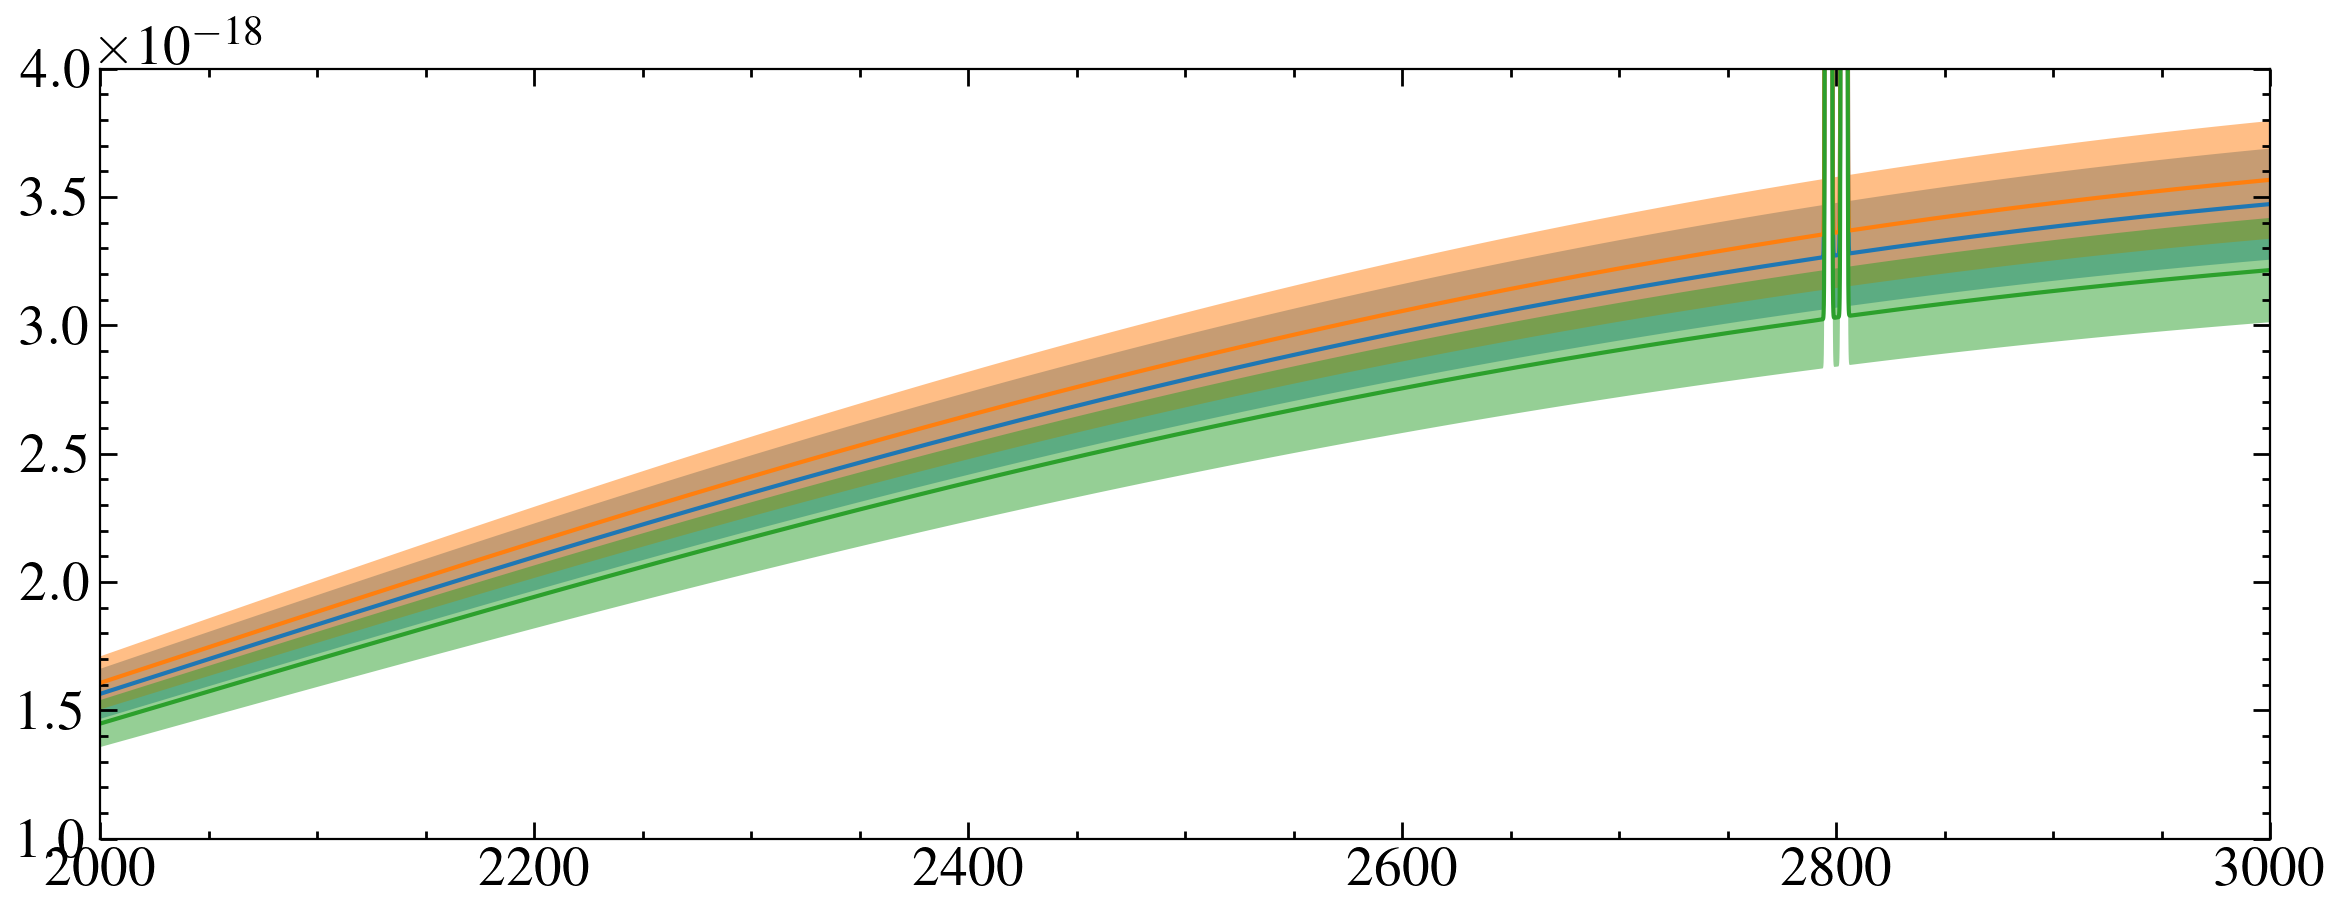

In [59]:
fig, ax = plt.subplots()


for i, mod in enumerate(mods):
    data = Table.read(mod)
    mw, mf, me = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     fix, ax = plt.subplots()
    # fig, ax = plt.subplot_mosaic([[0, 0, 0],[0,0,0], [1,1,1]], sharex=True, figsize=(12, 6))
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])
    
    # ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'WFC3 Photometry', zorder=10)
    # ax.set_yscale('log')
    ax.plot(mw, mf, label = 'NUV model')
    ax.fill_between(mw, mf+me, mf-me, alpha=0.5)

ax.set_ylim(0.1e-17, 0.4e-17)
ax.set_xlim(2000, 3000)

[2.65405580e-18 5.31213341e-18 3.80531641e-17]
3.8053164072176396e-17 4.2592891041233326e-19
[0.03334112]


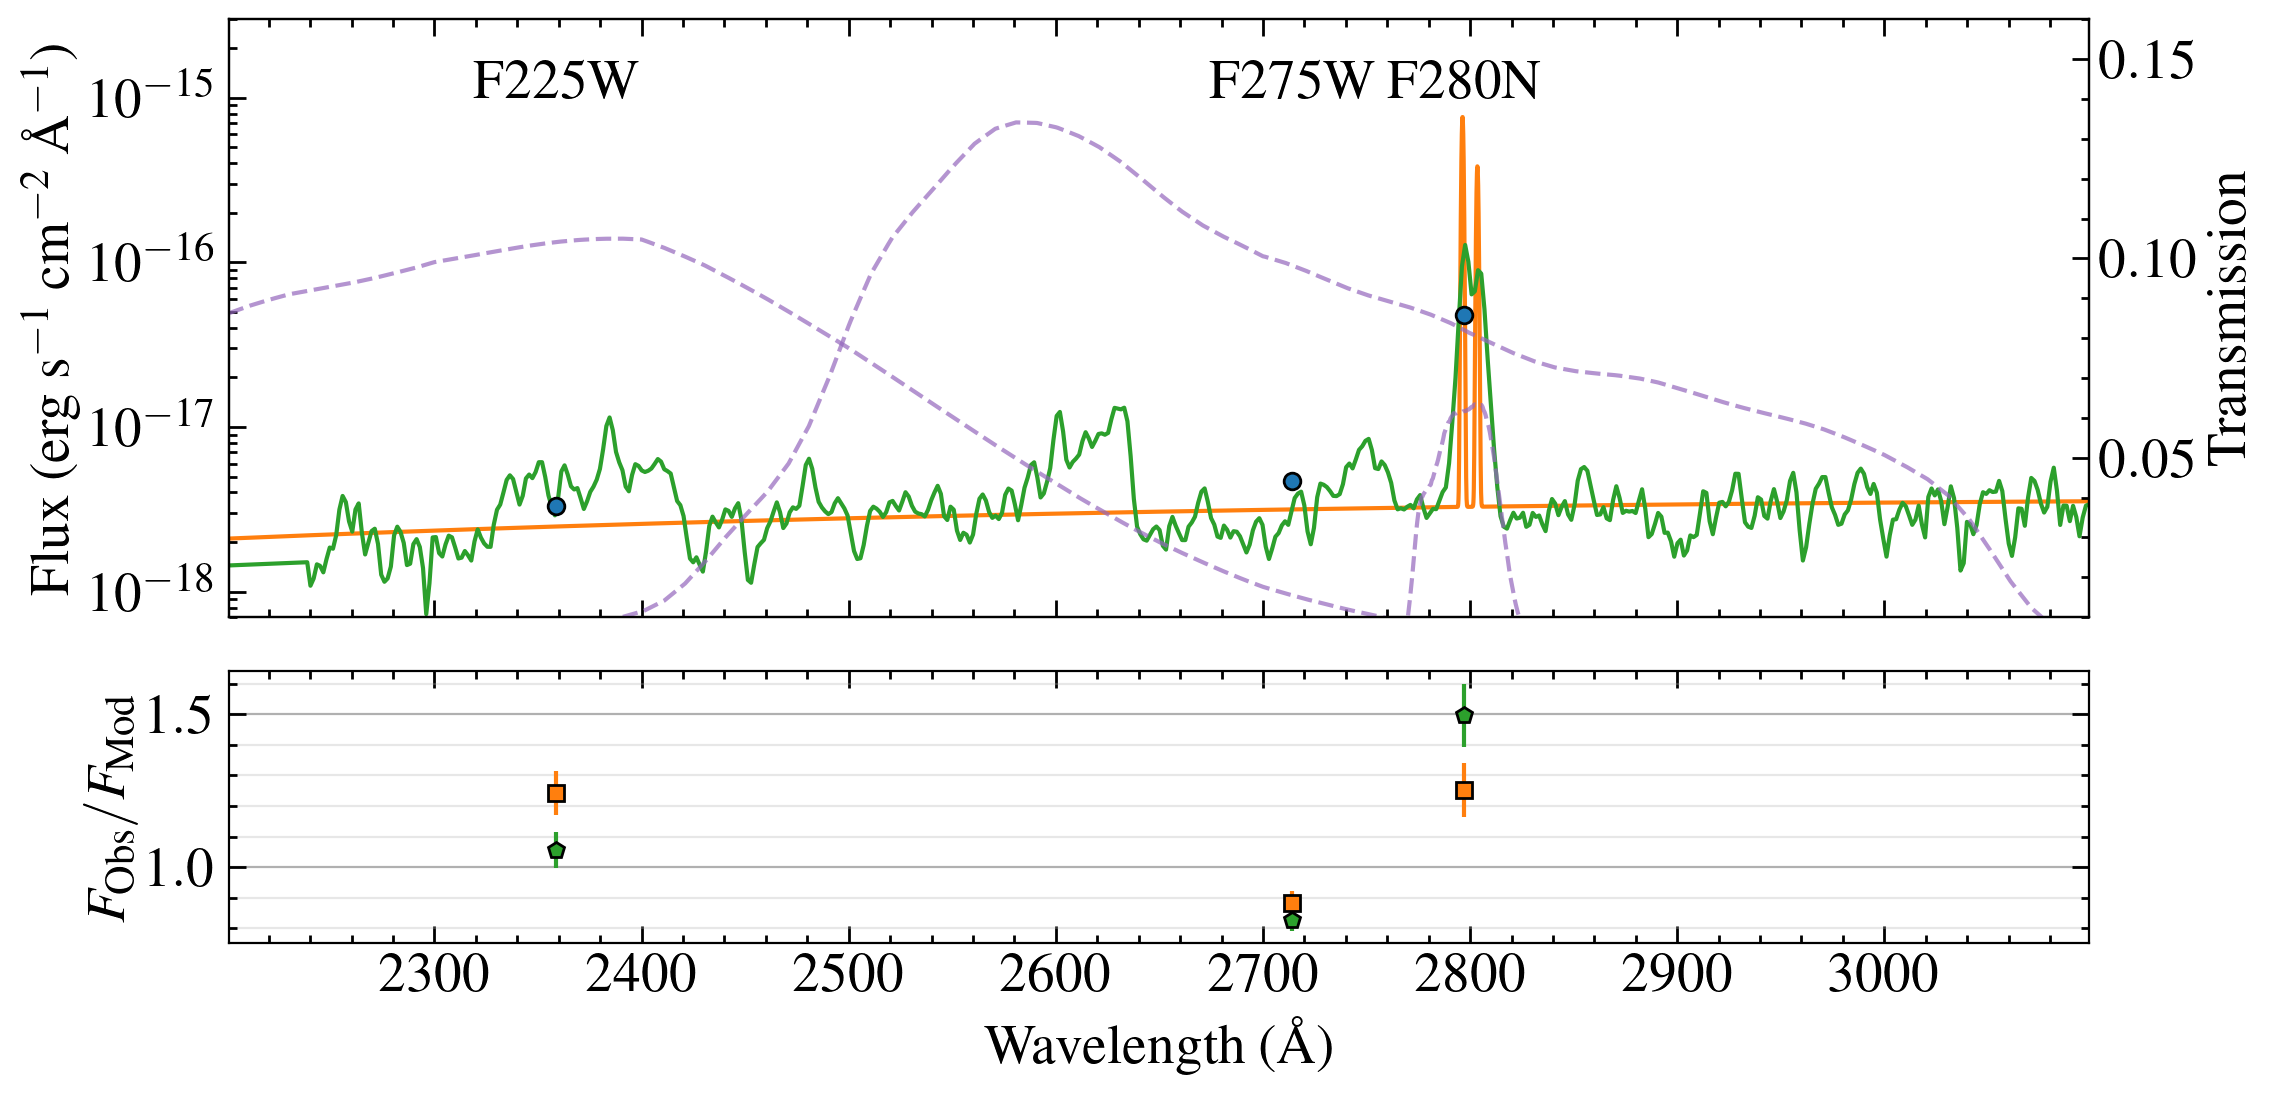

[2.69489095e-18 5.08886559e-18 3.32680672e-17]
3.326806724561868e-17 5.252689991502503e-19
[0.03263964]


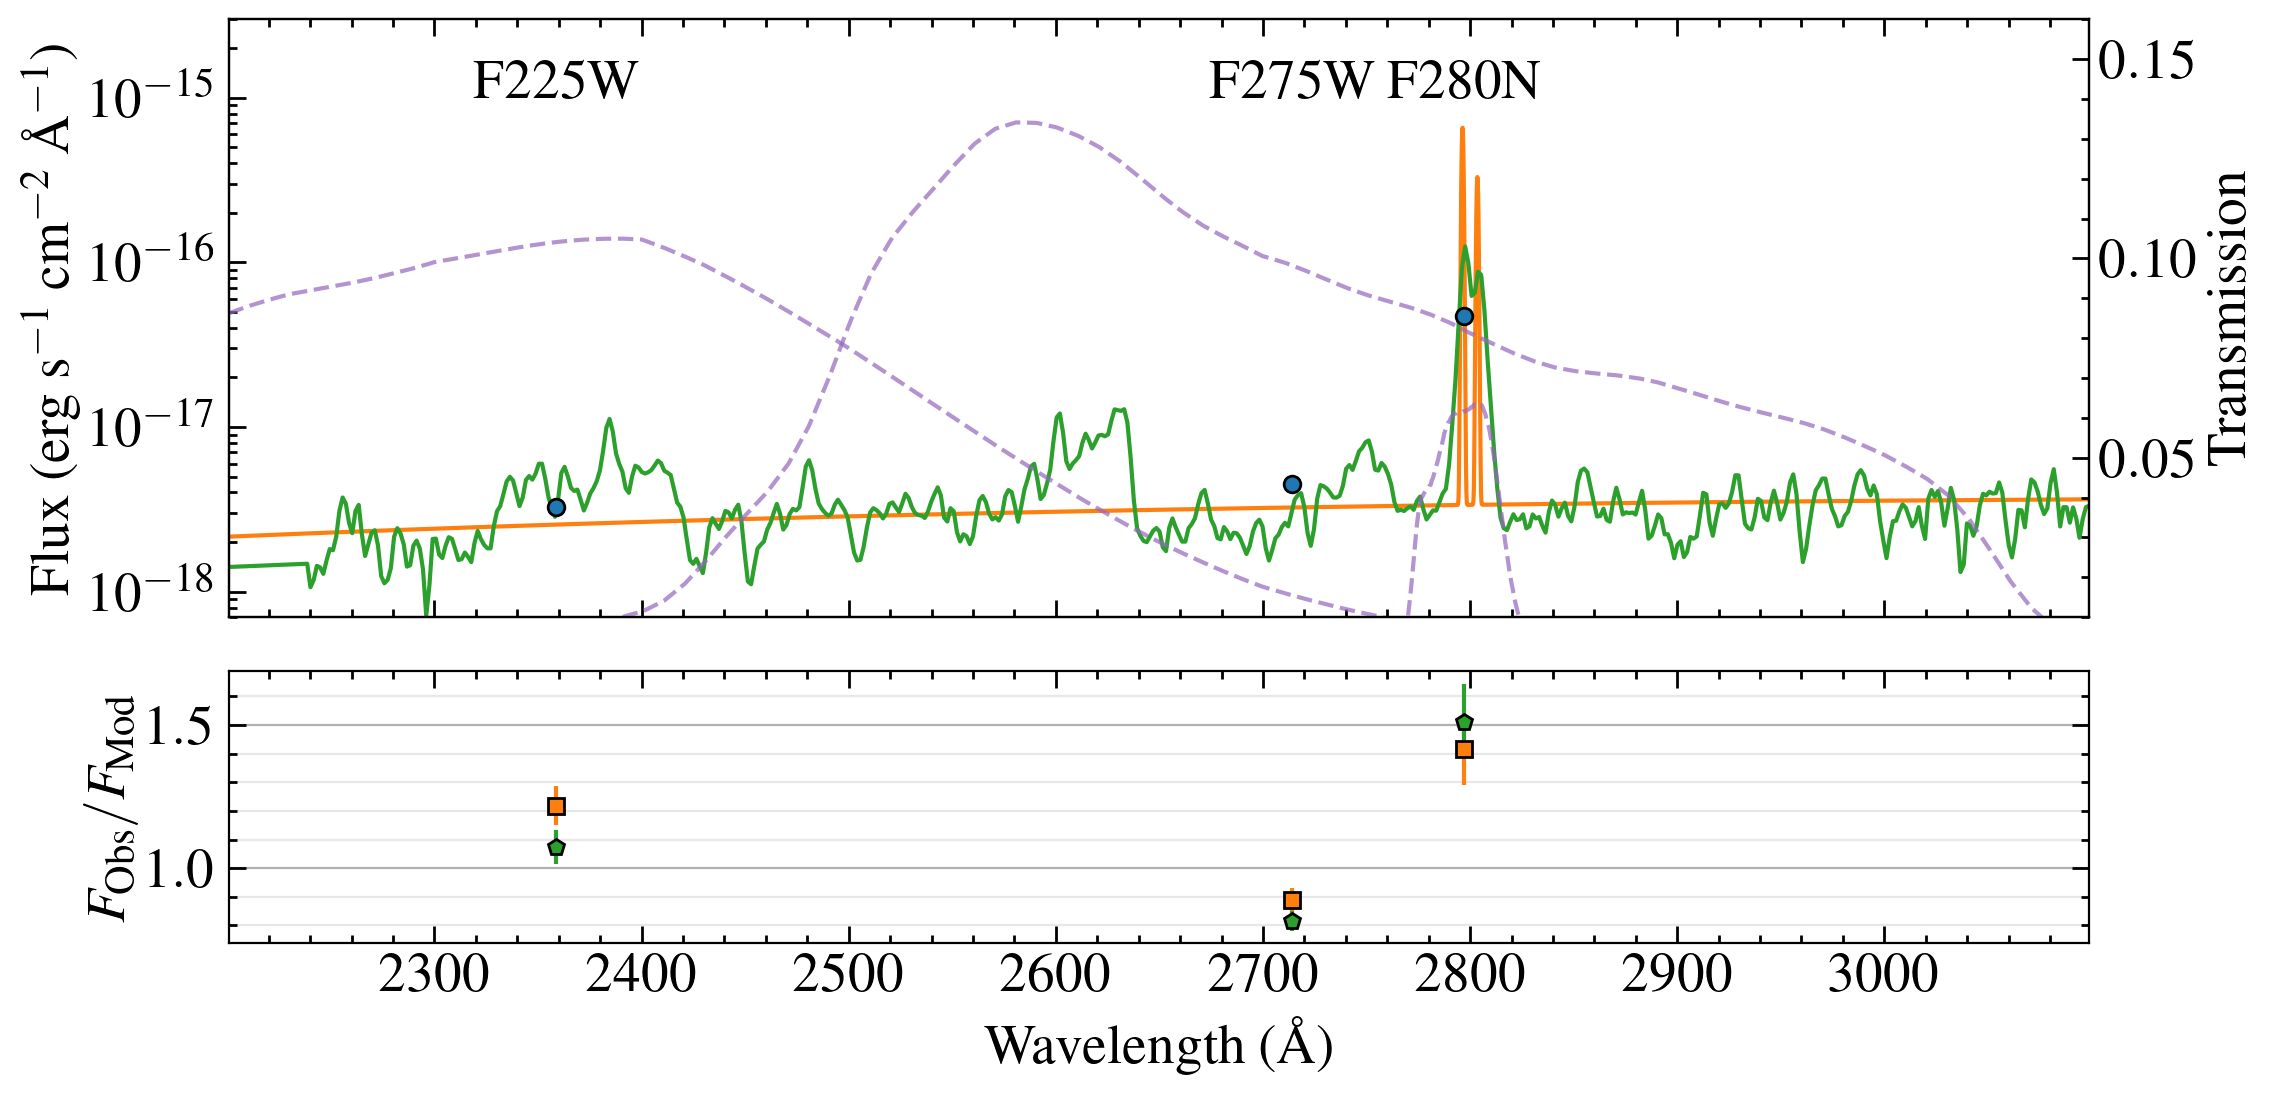

[2.42732128e-18 4.56428596e-18 2.96248024e-17]
2.962480236312536e-17 4.086686949328058e-19
[0.02721963]


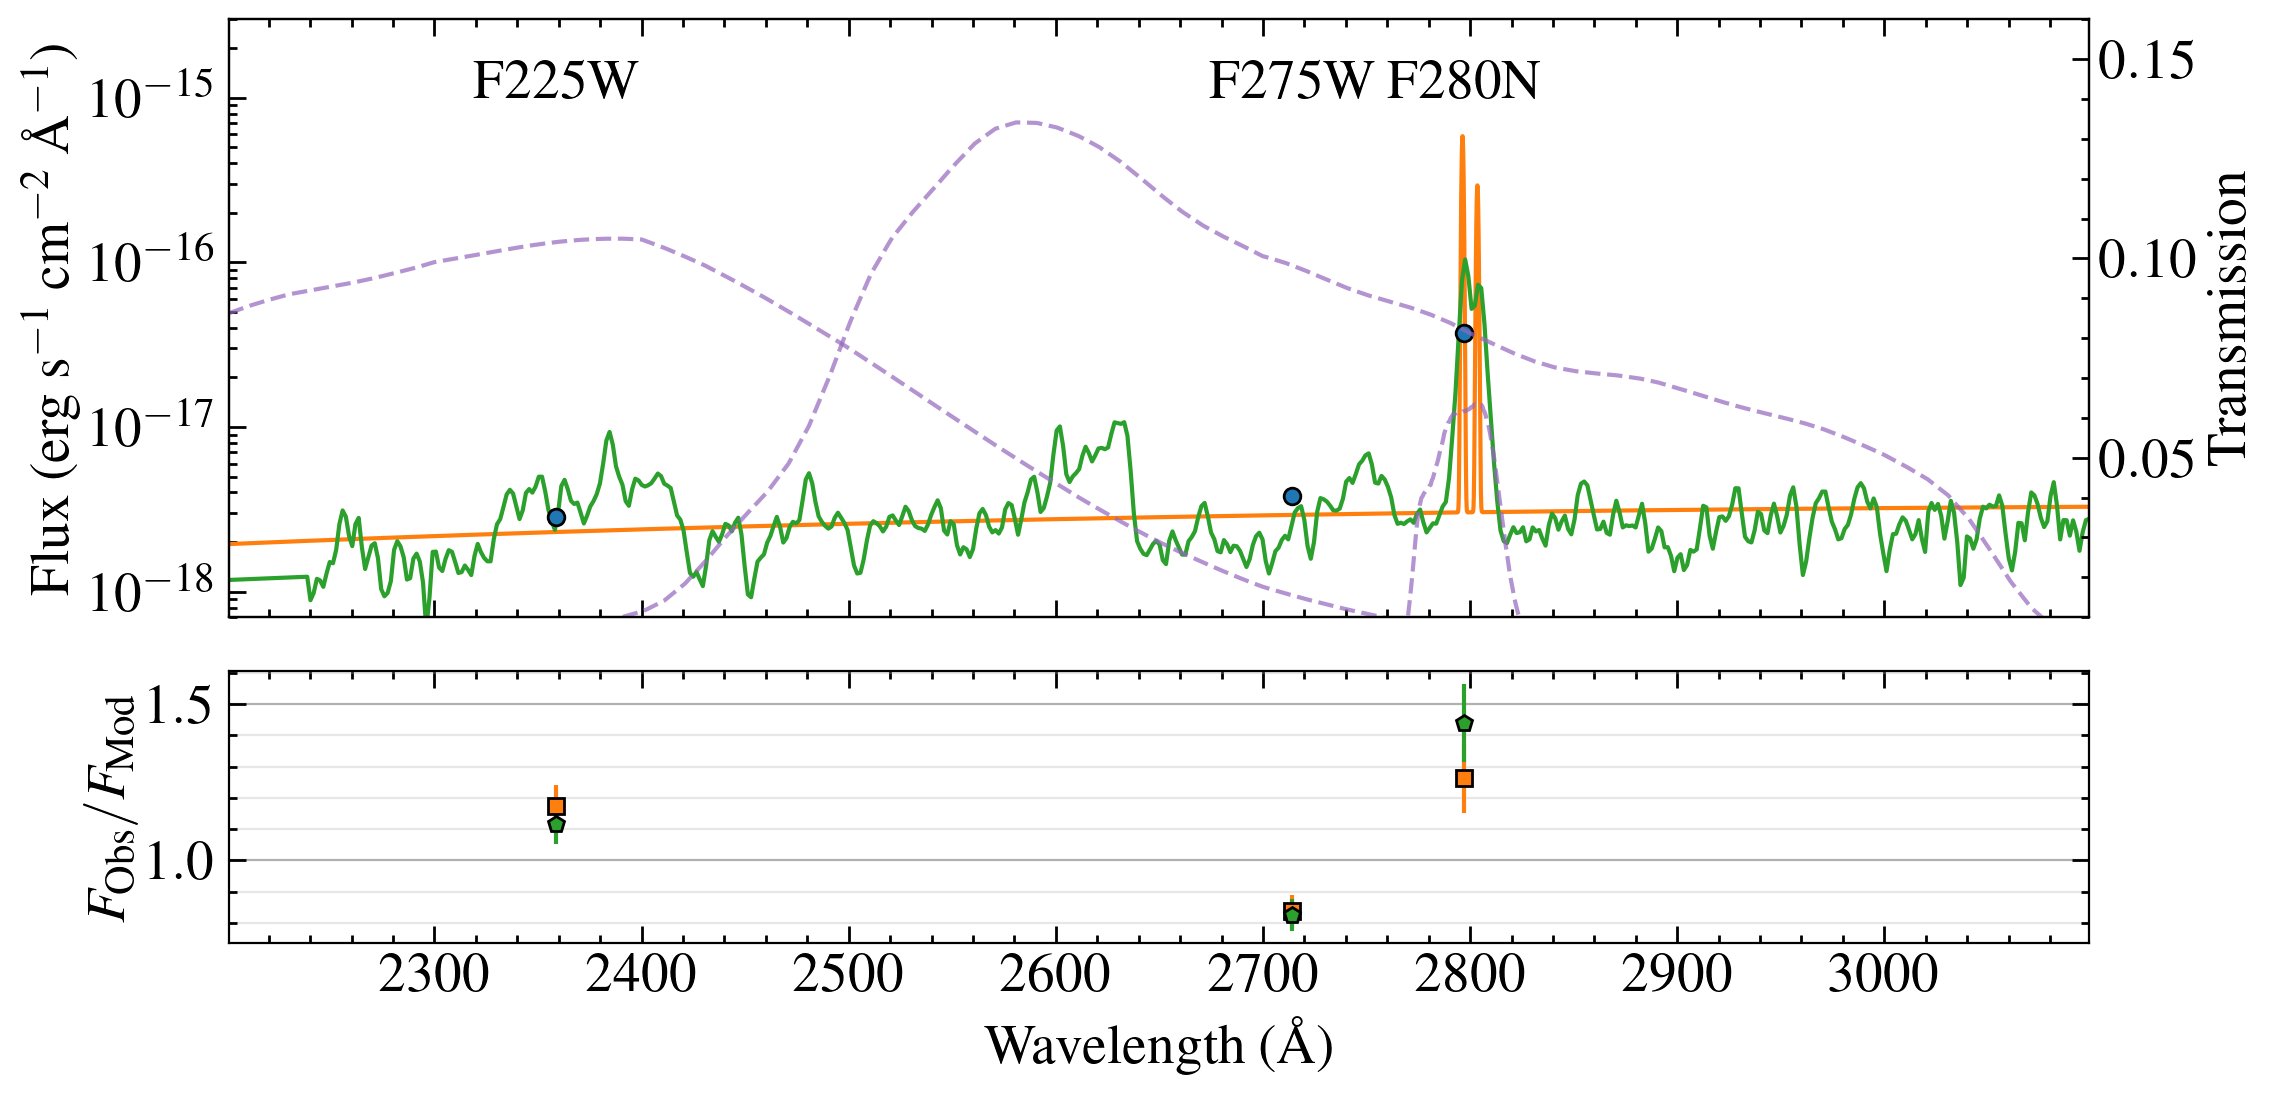

In [60]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 

def residuals(scale, f, mf):
    return f - mf/scale

prox_scales = []
gnfluxes = []
gnes = []


for i, mod in enumerate(mods):
    data = Table.read(mod)
    mw, mf, me = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     fix, ax = plt.subplots()
    fig, ax = plt.subplot_mosaic([[0, 0, 0],[0,0,0], [1,1,1]], sharex=True, figsize=(12, 6))
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])
    
    ax[0].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'WFC3 Photometry', zorder=10)
    ax[0].set_yscale('log')
    ax[0].plot(mw, mf, label = 'NUV model', c='C1')
    

    




# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1)
    
    ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
    ax[1].set_xlabel('Wavelength (\AA)')
    
    ax[0].tick_params(axis='x', which='both', labelbottom=False)
    
    ax[0].set_ylim(7e-19, 3e-15)
    ax[0].set_xlim(2201, 3099)
#     ax[1].set_xlim(2201, 3099)

    axr = ax[0].twinx()
    axr.set_ylim(0.01, 0.16)
    axr.set_ylabel('Transmission')
    
    mod_phots = []
    mod_phot_es = []
    for band in wbands:
        bpw, bpf = np.loadtxt(band, unpack=True)
        axr.plot(bpw, bpf, c='C4', ls='--', alpha=0.7)
        mphot, mphot_e = make_phot(bpw, bpf, mw, mf, me)
        mod_phots.append(mphot)
        mod_phot_es.append(mphot_e)
    mod_phots, mod_phot_es = np.array(mod_phots), np.array(mod_phot_es)
    print(mod_phots)


    gnw, gnt = np.loadtxt('/home/david/work/filters/galex/GALEX_GALEX.NUV.dat', unpack=True)  #galex nuv
    gnflux, gne = make_phot(bpw, bpf, mw, mf, me)
    print(gnflux, gne)
    gnfluxes.append(gnflux)
    gnes.append(gne)
    # axr.plot(gnw, gnt/10)
    # print(gnw[0])
    

    # ax[0].errorbar(phot_w, mod_phots, yerr=mod_phot_es, marker='s', ls='none', markeredgecolor='k', label = 'WFC3 Photometry', zorder=10)
    
    
    ratio = phot_f/mod_phots
    ratio_e = ratio * ((phot_e/phot_f)**2 + (mod_phot_es/mod_phots)**2)**0.5

    # sum = np.sum((phot_f - mod_phots)**2)
    # print(sum)
    
#     print(ratio, ratio_e)
    
    ax[1].errorbar(phot_w, ratio, yerr=ratio_e, marker='s', ls='none', markeredgecolor='k', c='C1')
    # ax[1].set_ylim(0.5, 3)
    # ax[1].set_yscale('log')
#     ax[1].axhline(1, ls ='--', c='0.5')

    


    ax[1].grid(axis='y')
    ax[1].grid(axis='y', which='minor', alpha=0.3)
    
    fnames = ['F225W', 'F275W', 'F280N']
    [ax[0].annotate(name, (wi, 1e-15), ha='center') for name, wi in zip(fnames, phot_w)]

    ax[1].set_ylabel(r'$F_{\mathrm{Obs}}/F_{\mathrm{Mod}}$')


    # proxy spectrum
    prox_phots = []
    for bpw, bpf in zip(bpws, bpfs):
        # phot = make_phot(bpw, bpf, wprox, fprox+mgmod)
        phot = make_phot(bpw, bpf, wprox, fprox)
        prox_phots.append(phot)

    scale = leastsq(residuals, 1., args=(phot_f, prox_phots))[0]
    scale_r = np.array([1, 1, 0.1])
    scale = leastsq(residuals, 1., args=(phot_f*scale_r, prox_phots*scale_r))[0]
    prox_scales.append(scale[0])


    
    # scale = leastsq(residuals, 1., args=(np.log10(phot_f), np.log10(prox_phots)))[0]
# scale = np.mean(mod_phots/phot_f)
    ax[0].plot(wprox, fprox/scale, label = 'LHS 2686 (scaled)', c='C2')
    print(1/scale)

    pratio = phot_f/(prox_phots/scale)
    pratio_e = pratio * phot_e/phot_f

    # sum = np.sum((phot_f - prox_phots/scale)**2)
    # print(sum)
    
    ax[1].errorbar(phot_w, pratio, yerr=pratio_e, marker='p', ls='none', markeredgecolor='k', c='C2')
    # ax[0].legend(frameon=True, loc=6)

    
#     print(bb_fixed_fit[3].temperature)
    
#     ax[0].legend(frameon=True, loc=4)
    # fig.savefig('plots/new_model_fits_epoch{}.pdf'.format(i+1))
    plt.show()
# savdat.write('model_spectra/t1_bb_model.txt', format='ascii.basic', overwrite=True) 
    # [2.65404828e-18 5.31213336e-18 3.80530882e-17]

[89.34158528 63.33529544 72.491     ]


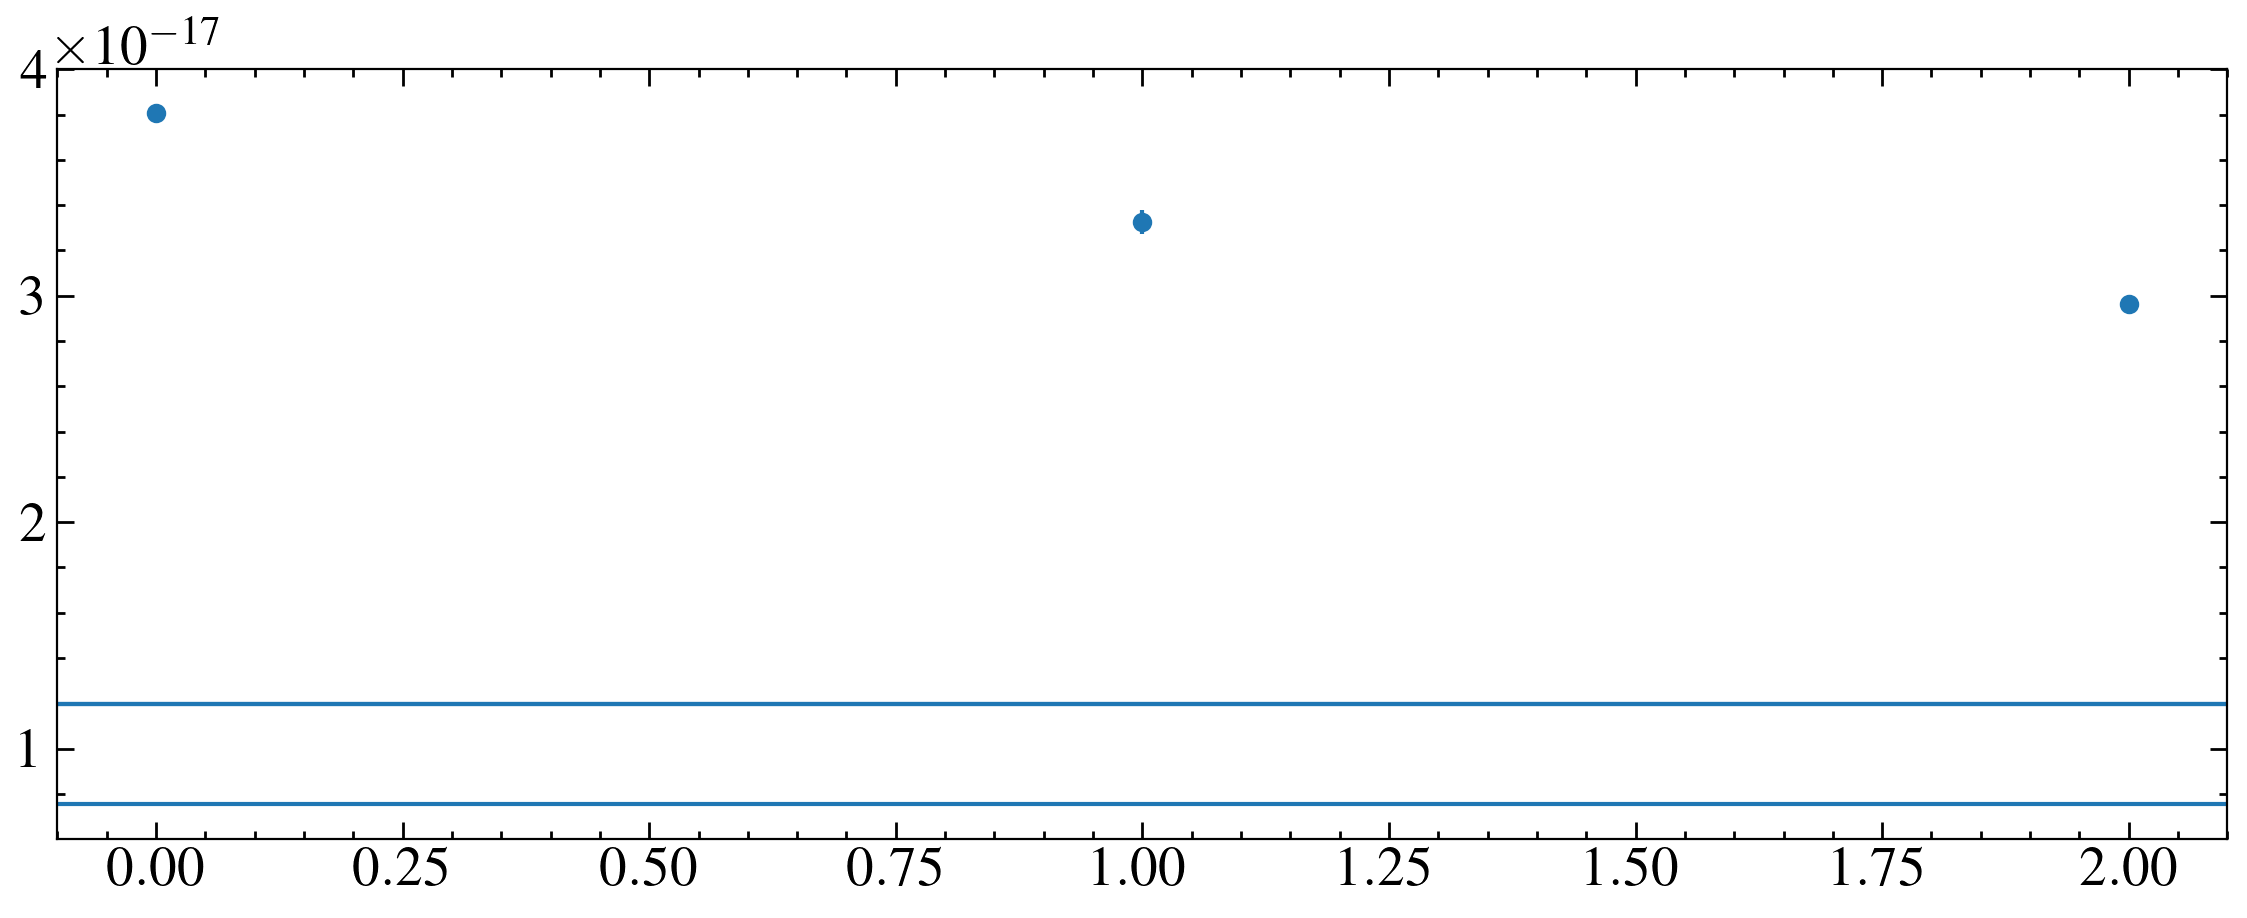

In [61]:
fig, ax = plt.subplots()

ax.errorbar(np.arange(3), gnfluxes, yerr=gnes, marker='o', ls='none')
print(np.array(gnfluxes)/np.array(gnes))

ax.axhline((10**-16.9)*(12.1/12.4)**2)
ax.axhline(10**-17.1*(12.1/12.4)**2)
ax.axhline(10**-16.9*(12.1/12.4)**2)

In [62]:
# [2.42731453e-18 4.56428593e-18 2.96247443e-17]
#scale by distance and lum

# lumt1 = 0.234 #e31
# lum_lhs = 1.078
# dt1 = 1000/80.4512
# dlhs = 1000/82.0336
# scale = ((dlhs/dt1)**2) * (lumt1/lum_lhs)**2
# scale

print(1/np.array(prox_scales))

[0.03334112 0.03263964 0.02721963]


In [63]:
# f = 250
# s = 350+480
# a = 150
# b = 350
# c = 65+85
# o = 110+50+10

# t = f+s+a+b+c+o

# print('sugar', '{:.0f}'.format((s/t)*100),'%')
# print('apple sauce','{:.0f}'.format((a/t)*100),'%')
# print('vegan butter','{:.0f}'.format((b/t)*100),'%')
# print('flour', '{:.0f}'.format((f/t)*100),'%')
# print('cocoa', '{:.0f}'.format((c/t)*100),'%')
# print('other', '{:.0f}'.format((o/t)*100),'%')

In [64]:
fe = Table.read('fe_lines.csv')

In [65]:
# fe.dtype.names

In [66]:
# plt.plot(fe['obs_wl_vac(A)'], fe['intens'])

In [67]:
# plt.hist(fe['intens'])

In [68]:
# fe['intens']

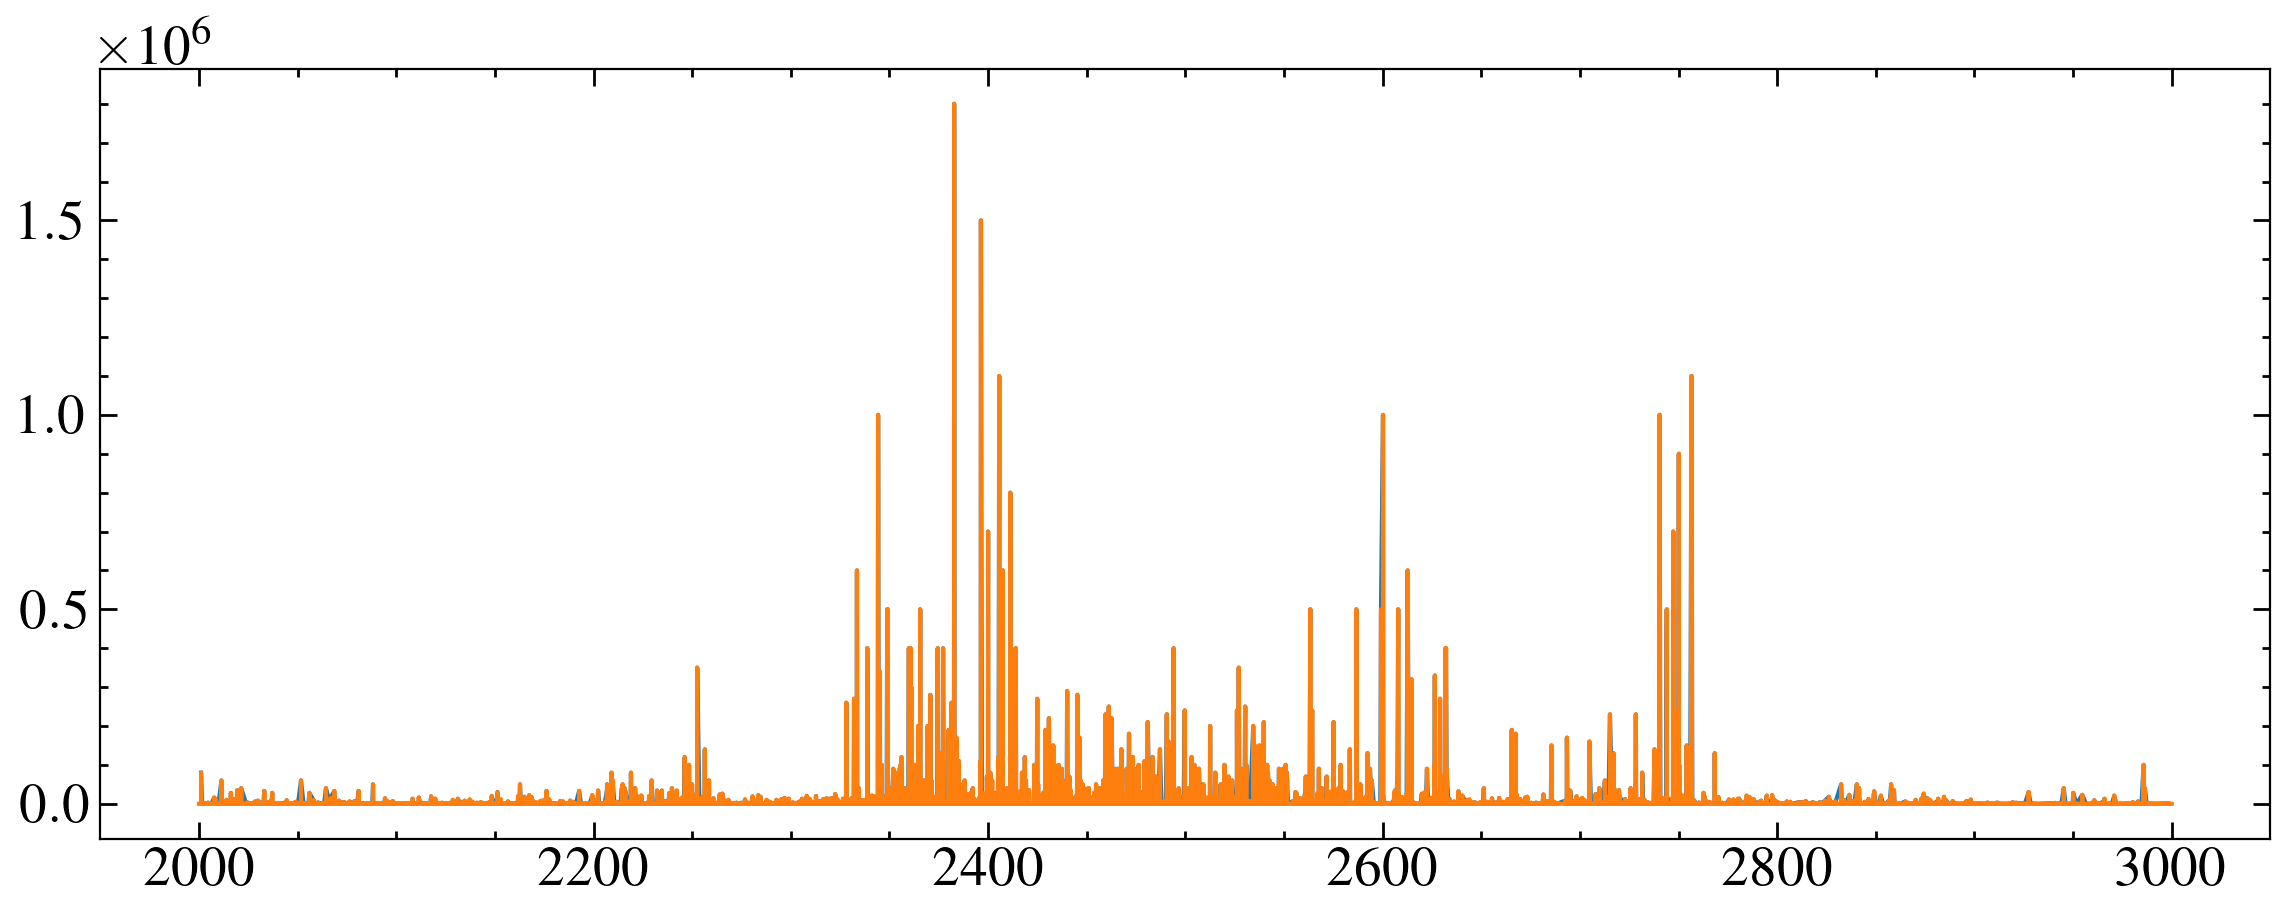

In [69]:
intens= np.array([i.replace('"', '').replace('=','') for i in fe['intens']])
imask = np.array([i.isdigit() for i in intens])

# print(len(fe['obs_wl_vac(A)']))
mask = fe['obs_wl_vac(A)'][imask] != '=""'

# print(len(fe['obs_wl_vac(A)'][mask]))

w_fe = np.array([float(wi.replace('"', '').replace('=','')) for wi in fe['obs_wl_vac(A)'][imask][mask]])

# gi_max = gi_max = max(fe['g_i'][mask])

# plt.plot(w_fe, fe['g_i'][mask])

intens = intens[imask][mask]
intens = np.array([float(i) for i in intens])



plt.plot(w_fe, intens)


w_flat = np.arange(2000, 3000, 0.001)
f_flat = np.zeros(len(w_flat))

w_fe = np.hstack((w_flat, w_fe))
f_fe = np.hstack((f_flat, intens))
args = np.argsort(w_fe)
w_fe, f_fe = w_fe[args], f_fe[args]

plt.plot(w_fe, f_fe)

In [71]:
# fig, ax = plt.subplots()

# ax.plot(wprox, fprox, label = 'LHS 2686 (scaled)', c='C0', alpha =0.9)
# # 

# fmod = (f_fei*0.3e-20) + bb_fe

# # fmod = convolve(fmod, Gaussian1DKernel(3))
# fmod = convolve(fmod, Box1DKernel(3))

# # ax.plot(w_fe, intens_s*0.5e-20, alpha=0.7)

# ax.set_yscale('log')

# # ax.step(wn, fn, where='mid')


# bb_fe = bb_fit(w_fe) 

# ax.plot(w_fe,fmod , alpha=0.9, c='C1')



Making a new model with the Fe lines. From the science notebook.
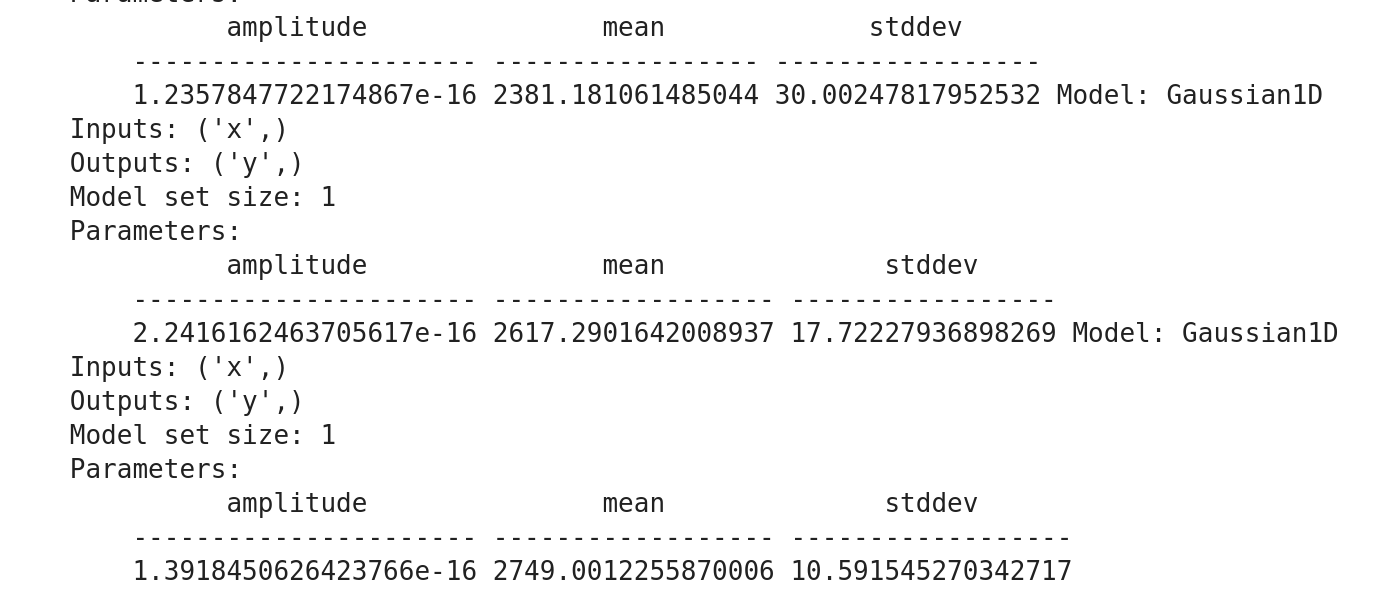

In [72]:
mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]
# def nuv_fit(x, amplitude=1e-16, scale=1e-25, fe_amp = 1.3e-16):

@custom_model
def nuv_fit(x, amplitude=1.0, scale=1.0, fe_amp=1.0 ):
    return nuv_phot_model(amplitude, scale, fe_amp)

def nuv_phot_model(amp_in, scale_in, fe_amp_in):
    mg_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=(amp_in/(os[0]/os[1]))*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True))
    def tiedamp(mod):
        amplitude = mod.amplitude_0.value/(os[0]/os[1])
        return amplitude
  
    mg_mod.amplitude_1.tied = tiedamp
        
    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))
    # print(bb_mod.scale)
    bb_mod.scale.min= 0

    fe_amps = [1.3e-16, 2.3e-16,1.4e-16]
    r1 = fe_amps[0]/fe_amps[1]
    r2 = fe_amps[0]/fe_amps[2]
    

    fe_mod = models.Gaussian1D(amplitude = fe_amp_in*u.erg/u.s/u.cm**2/u.AA, mean = 2380*u.AA, stddev = 30*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = (fe_amp_in/r1)*u.erg/u.s/u.cm**2/u.AA, mean = 2620*u.AA, stddev = 20*u.AA, fixed = dict(mean=True, stddev=True)) 
    # + models.Gaussian1D(amplitude = (fe_amp_in/r2)*u.erg/u.s/u.cm**2/u.AA, mean = 2750*u.AA, stddev = 10*u.AA, fixed = dict(mean=True, stddev=True))

    def tied1(mod):
        amplitude = mod.amplitude_0.value/r1
        return amplitude
    def tied2(mod):
        amplitude = mod.amplitude_0.value/r2
        return amplitude
    
    fe_mod.amplitude_1.tied = tied1
    # fe_mod.amplitude_2.tied = tied2

    # bb_mod.scale = abs(bb_mod.scale)
    

    
    # nuv_mod = mg_mod+bb_mod
    mod_w = np.linspace(1900, 3500, 100000)*u.AA


    bb_mod = bb_mod(mod_w).value
    mg_mod = mg_mod(mod_w).value
    fe_mod = fe_mod(mod_w).value
    mod_w = mod_w.value

    mod_spec = mg_mod + bb_mod+fe_mod
    
    # mod_spec = nuv_mod(mod_w)

    wbands= glob.glob('filters/*UVIS*')
    wbands.sort()


    
    mod_phots = []
    for band in wbands:
        bpw, bpf = np.loadtxt(band, unpack=True)
        phot = make_phot(bpw, bpf, mod_w, mod_spec)
        mod_phots.append(phot)



    return(np.array(mod_phots))






Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude scale
    --------- -----
        1e-20 1e-14


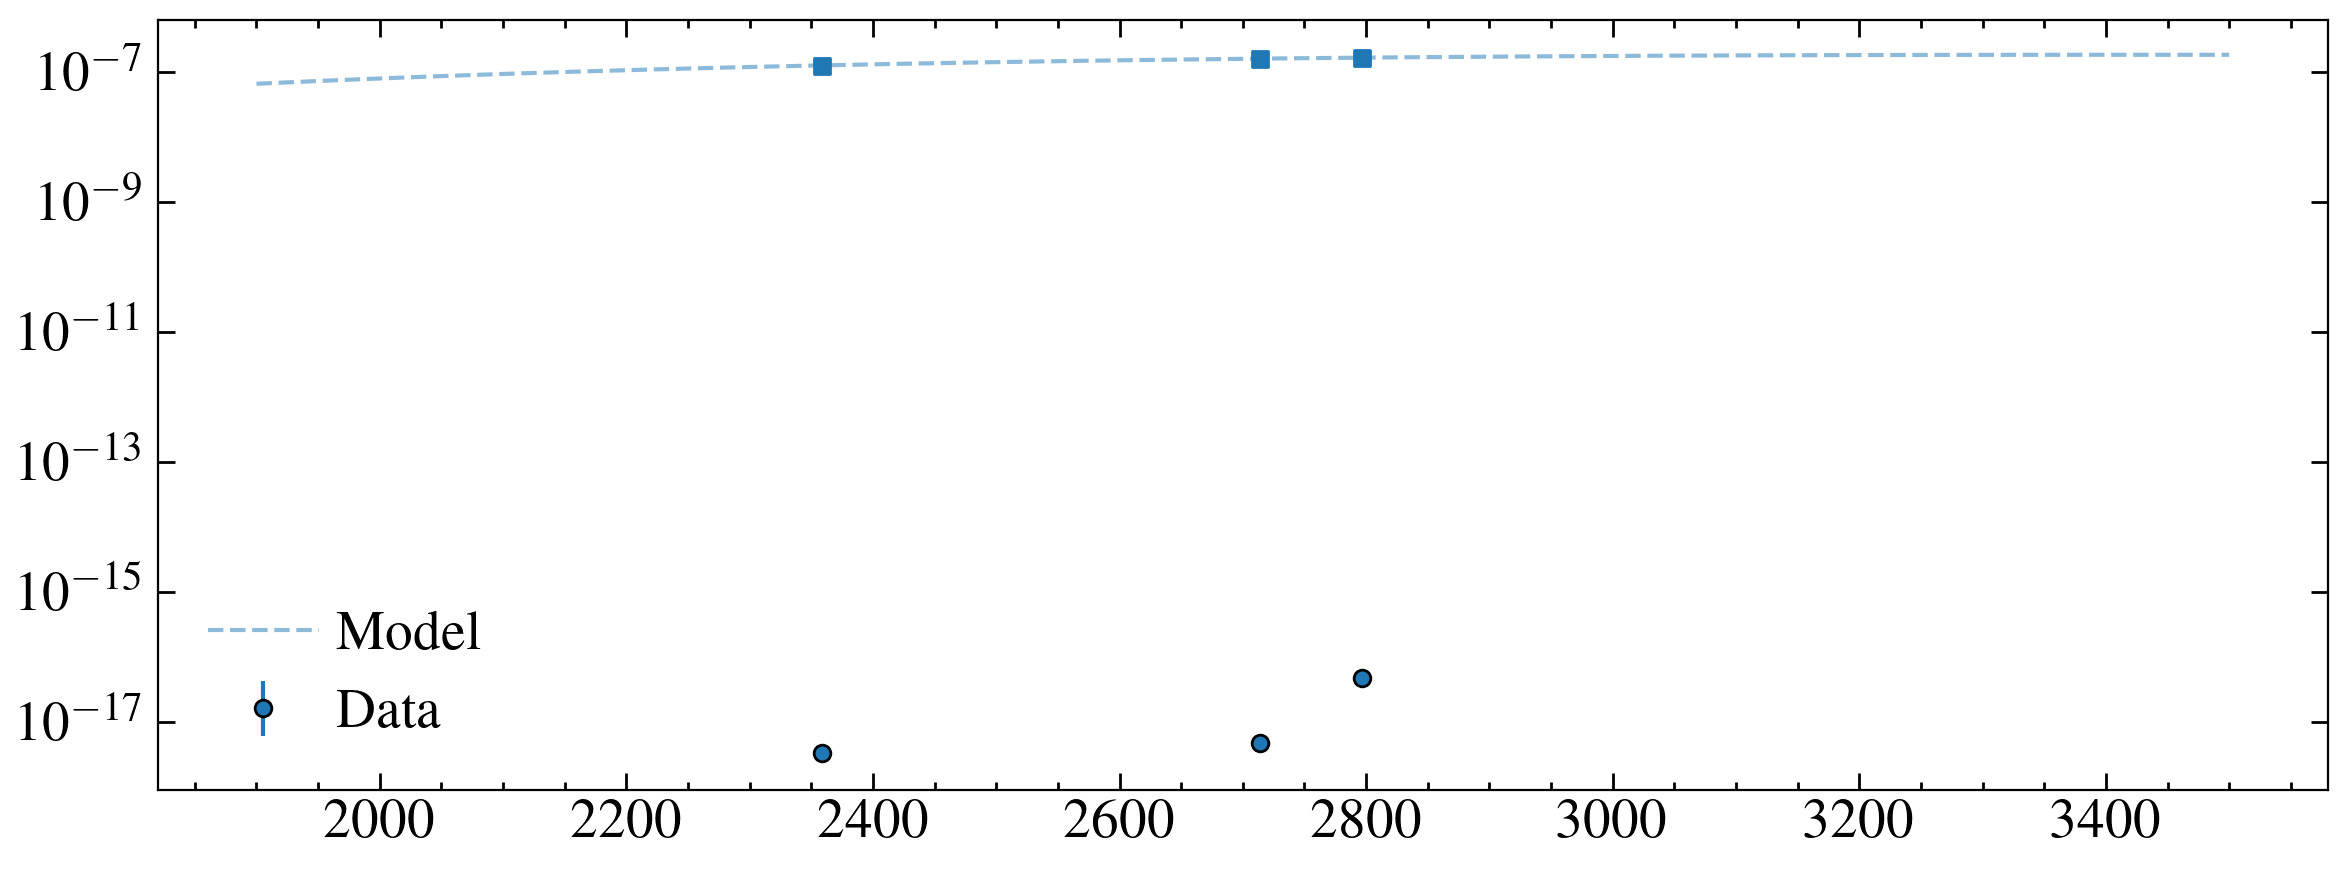

In [112]:
fitter= fitting.LevMarLSQFitter()


mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]
# def nuv_fit(x, amplitude=1e-16, scale=1e-25, fe_amp = 1.3e-16):

@custom_model
def nuv_fit(x, amplitude=1.0, scale=1.0):
    return nuv_phot_model(amplitude, scale)

def nuv_phot_model(amp_in, scale_in):
    fe_amps = [1.3e-16, 2.3e-16,1.4e-16]
    r0 = fe_amps[0]/7.64e-16
    r1 = fe_amps[0]/fe_amps[1]
    r2 = fe_amps[0]/fe_amps[2]

    lines_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=(amp_in/(os[0]/os[1]))*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = fe_amps[0]/r0*u.erg/u.s/u.cm**2/u.AA, mean = 2380*u.AA, stddev = 30*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = (fe_amps[1]/r1)*u.erg/u.s/u.cm**2/u.AA, mean = 2620*u.AA, stddev = 20*u.AA, fixed = dict(mean=True, stddev=True))+ models.Gaussian1D(amplitude = (fe_amps[2]/r2)*u.erg/u.s/u.cm**2/u.AA, mean = 2750*u.AA, stddev = 10*u.AA, fixed = dict(mean=True, stddev=True))

 
    
    def tiedamp(mod):
        amplitude = mod.amplitude_0.value/(os[0]/os[1])
        return amplitude
    
    def tied0(mod):
        amplitude = amplitude_2.value/r0
    
    def tied1(mod):
        amplitude = amplitude_2.value/r1
        return amplitude
    def tied2(mod):
        amplitude = amplitude_2.value/r2
        return amplitude
  
    lines_mod.amplitude_1.tied = tiedamp
    lines_mod.amplitude_2.tied = tied0
    lines_mod.amplitude_3.tied = tied1
    lines_mod.amplitude_4.tied = tied2


        
    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True, scale=True))


    

    
    # nuv_mod = mg_mod+bb_mod

    
    mod_w = np.linspace(1900, 3500, 100000)*u.AA

    
    bb_mod = bb_mod(mod_w).value
    lines_mod = lines_mod(mod_w).value
    mod_w = mod_w.value

    mod_spec = lines_mod + bb_mod

    
    # mod_spec = nuv_mod(mod_w)

    wbands= glob.glob('filters/*UVIS*')
    wbands.sort()


    
    mod_phots = []
    for band in wbands:
        bpw, bpf = np.loadtxt(band, unpack=True)
        phot = make_phot(bpw, bpf, mod_w, mod_spec)
        mod_phots.append(phot)



    return(np.array(mod_phots))






def nuv_fe_model(amp_in, scale_in):

    fe_amps = [1.3e-16, 2.3e-16,1.4e-16]
    r0 = fe_amps[0]/7.64e-16
    r1 = fe_amps[0]/fe_amps[1]
    r2 = fe_amps[0]/fe_amps[2]

    lines_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=(amp_in/(os[0]/os[1]))*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = fe_amps[0]/r0*u.erg/u.s/u.cm**2/u.AA, mean = 2380*u.AA, stddev = 30*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = (fe_amps[1]/r1)*u.erg/u.s/u.cm**2/u.AA, mean = 2620*u.AA, stddev = 20*u.AA, fixed = dict(mean=True, stddev=True))+ models.Gaussian1D(amplitude = (fe_amps[2]/r2)*u.erg/u.s/u.cm**2/u.AA, mean = 2750*u.AA, stddev = 10*u.AA, fixed = dict(mean=True, stddev=True))

 
    
    def tiedamp(mod):
        amplitude = mod.amplitude_0.value/(os[0]/os[1])
        return amplitude
    
    def tied0(mod):
        amplitude = amplitude_2.value/r0
    
    def tied1(mod):
        amplitude = amplitude_2.value/r1
        return amplitude
    def tied2(mod):
        amplitude = amplitude_2.value/r2
        return amplitude
  
    lines_mod.amplitude_1.tied = tiedamp
    lines_mod.amplitude_2.tied = tied0
    lines_mod.amplitude_3.tied = tied1
    lines_mod.amplitude_4.tied = tied2


        
    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True, scale=True))


    

    
    # nuv_mod = mg_mod+bb_mod
    mod_w = np.linspace(1900, 3500, 100000)*u.AA

    
    bb_mod = bb_mod(mod_w).value
    lines_mod = lines_mod(mod_w).value
    # fe_mod = fe_mod(mod_w).value
    mod_w = mod_w.value

    mod_spec = lines_mod + bb_mod

    
    return mod_w, mod_spec
    








fig, ax = plt.subplots()


# fig, ax 


# amps = []
# amps_e = []
# scales = []
# scales_e = []

for i in range(1):
    phot_w = np.array([2358.7, 2713.86, 2796.94])
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])

    mod_in = nuv_fit(1e-16, 1e-25, bounds = dict(amplitude=[1e-20, 1e-12], scale=[1e-14, 1e-10]))
    # print(mod_in)

    # guess_modw, guess_modf = nuv_fe_model(1e-15, 1e-30)

    # ax.plot(guess_modw, guess_modf, ls='--')
    #
    # kwargs = (1e-16, 1e-15, bpws, bpfs)

    fit = fitter(mod_in, np.arange(3),  phot_f, weights = 1/phot_e, maxiter = 100000)
    # fit = fitter(mod_in, np.arange(3),  phot_f, maxiter = 100000)
    # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

    print(fit)
    # print(fit, fit_e)

    # amps.append(fit.amplitude.value)
    # amps_e.append(fit_e[0])
    # scales.append(fit.scale.value)
    # scales_e.append(fit_e[1])

    
    ax.errorbar(phot_w+(i*10), phot_f, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'Data', zorder=12, c='C{}'.format(i))

    mod_w, mod_f = nuv_fe_model(fit.amplitude,fit.scale)
# ax.errorbar(phot_w, mod_phots, marker='s', ls='none', label = 'WFC3', zorder=13, markeredgecolor='k')
    ax.plot(mod_w, mod_f, ls='--', alpha=0.5, c='C{}'.format(i), label='Model')
    ax.scatter(phot_w+(i*10), fit(phot_w), c='C{}'.format(i), marker = 's')
    # print(fit(np.arange(3)))
    # print(np.trapz(mod_f, mod_f))

ax.set_yscale('log')

# plt.show()

# fig, ax = plt.subplots()

# ax.errorbar(days, amps, yerr=amps_e, marker='o')
# plt.show()
# fig, ax = plt.subplots()
ax.legend()
# # ax.errorbar(days, scales, yerr=scales_e, marker='o')


Need a new approach - build the line model and just have it scaling as a factor

Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       mg_amplitude    scale     fe_amplitude   
    ------------------ ----- -------------------
    1.0464246171342808 1e-25 0.04085669845550012
Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       mg_amplitude    scale     fe_amplitude   
    ------------------ ----- -------------------
    0.9097630913370051 1e-25 0.04303611859341898
Model: nuv_fit
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       mg_amplitude    scale     fe_amplitude    
    ------------------ ----- --------------------
    0.8044196782010465 1e-25 0.034704264867373415


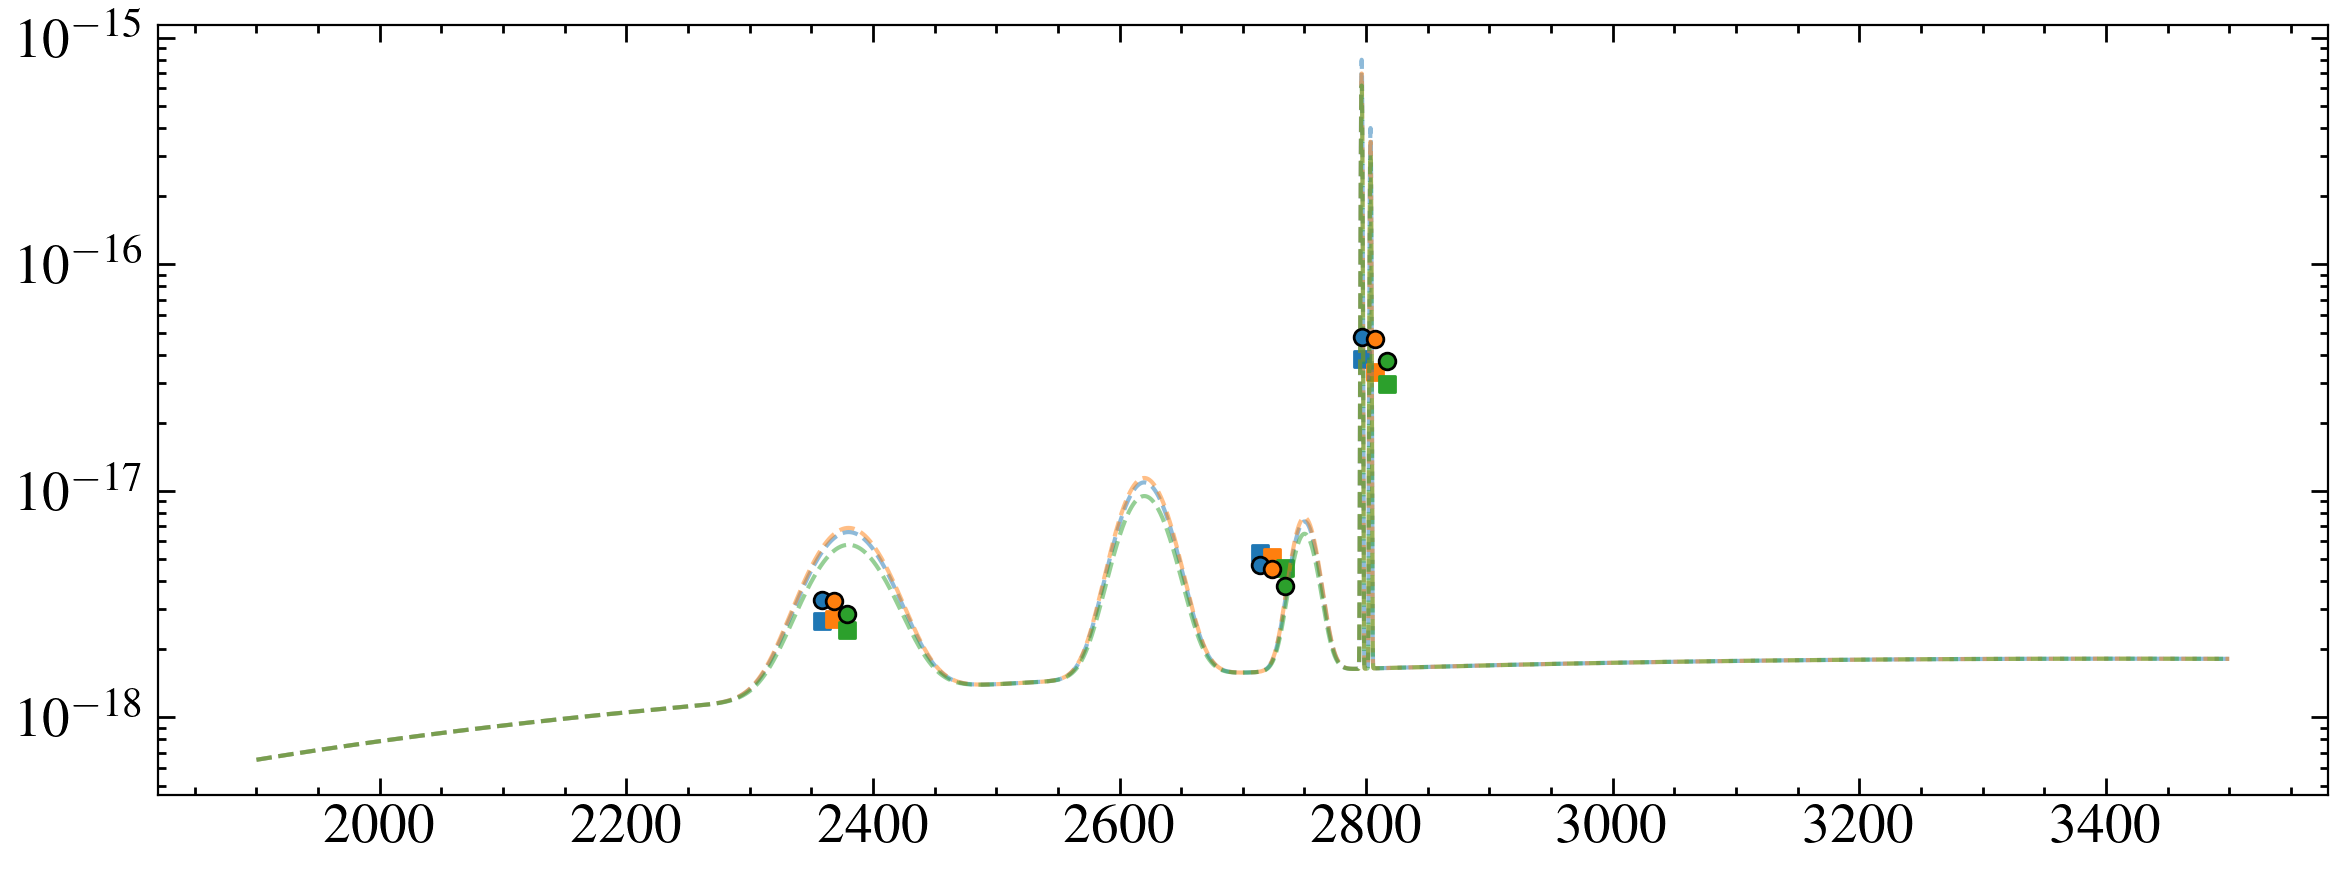

In [163]:
fitter= fitting.LevMarLSQFitter()


mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]
# def nuv_fit(x, amplitude=1e-16, scale=1e-25, fe_amp = 1.3e-16):



@custom_model
def nuv_fit(x, mg_amplitude=1.0, scale=1.0, fe_amplitude=1.0):
    return nuv_phot_model(mg_amplitude, scale, fe_amplitude)

def nuv_phot_model(amp_in, scale_in, fe_in):



   

    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))


    

    
    # nuv_mod = mg_mod+bb_mod

    
    mod_w = np.linspace(1900, 3500, 100000)*u.AA

    
    bb_mod = bb_mod(mod_w).value
    mg_mod = amp_in * mg_lines()(mod_w).value 
    fe_mod = fe_in * fe_lines()(mod_w).value 
    mod_w = mod_w.value

    mod_spec = mg_mod + fe_mod + bb_mod

    
    # mod_spec = nuv_mod(mod_w)

    wbands= glob.glob('filters/*UVIS*')
    wbands.sort()


    
    mod_phots = []
    for band in wbands:
        bpw, bpf = np.loadtxt(band, unpack=True)
        phot = make_phot(bpw, bpf, mod_w, mod_spec)
        mod_phots.append(phot)



    return(np.array(mod_phots))
    
def mg_lines():
    mg2 = [2796.352, 2803.53]
    os = [6.08e-01, 3.03e-01]
    mg_amps = [7.64e-16, 7.64e-16/(os[0]/os[1])]
    lines_mod = models.Gaussian1D(amplitude=mg_amps[0]*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(amplitude=True, mean=True, stddev=True)) + models.Gaussian1D(amplitude=mg_amps[1]*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(amplitude=True,mean=True, stddev=True))
    return lines_mod
    

def fe_lines():
    fe_amps = [1.3e-16, 2.3e-16,1.4e-16]
    lines_mod = models.Gaussian1D(amplitude = fe_amps[0]*u.erg/u.s/u.cm**2/u.AA, mean = 2380*u.AA, stddev = 30*u.AA, fixed = dict(amplitude=True,mean=True, stddev=True)) + models.Gaussian1D(amplitude = fe_amps[1]*u.erg/u.s/u.cm**2/u.AA, mean = 2620*u.AA, stddev = 20*u.AA, fixed = dict(amplitude=True,mean=True, stddev=True))+ models.Gaussian1D(amplitude = fe_amps[2]*u.erg/u.s/u.cm**2/u.AA, mean = 2750*u.AA, stddev = 10*u.AA, fixed = dict(amplitude=True,mean=True, stddev=True))
    return lines_mod


def nuv_spectrum_model(amp_in, scale_in, fe_in):



   

    bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))
  
    
    mod_w = np.linspace(1900, 3500, 100000)*u.AA

    
    bb_mod = bb_mod(mod_w).value
    mg_mod = amp_in * mg_lines()(mod_w).value 
    fe_mod = fe_in * fe_lines()(mod_w).value 
    mod_w = mod_w.value

    mod_spec = mg_mod + fe_mod + bb_mod


    return mod_w, mod_spec




# def nuv_fe_model(amp_in, scale_in):

#     fe_amps = [1.3e-16, 2.3e-16,1.4e-16]
#     r0 = fe_amps[0]/7.64e-16
#     r1 = fe_amps[0]/fe_amps[1]
#     r2 = fe_amps[0]/fe_amps[2]

#     lines_mod = models.Gaussian1D(amplitude=amp_in*u.erg/u.s/u.cm**2/u.AA, mean = mg2[0]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=(amp_in/(os[0]/os[1]))*u.erg/u.s/u.cm**2/u.AA, mean = mg2[1]*u.AA, stddev=0.5*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = fe_amps[0]/r0*u.erg/u.s/u.cm**2/u.AA, mean = 2380*u.AA, stddev = 30*u.AA, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude = (fe_amps[1]/r1)*u.erg/u.s/u.cm**2/u.AA, mean = 2620*u.AA, stddev = 20*u.AA, fixed = dict(mean=True, stddev=True))+ models.Gaussian1D(amplitude = (fe_amps[2]/r2)*u.erg/u.s/u.cm**2/u.AA, mean = 2750*u.AA, stddev = 10*u.AA, fixed = dict(mean=True, stddev=True))

 
    
#     def tiedamp(mod):
#         amplitude = mod.amplitude_0.value/(os[0]/os[1])
#         return amplitude
    
#     def tied0(mod):
#         amplitude = amplitude_2.value/r0
    
#     def tied1(mod):
#         amplitude = amplitude_2.value/r1
#         return amplitude
#     def tied2(mod):
#         amplitude = amplitude_2.value/r2
#         return amplitude
  
#     lines_mod.amplitude_1.tied = tiedamp
#     lines_mod.amplitude_2.tied = tied0
#     lines_mod.amplitude_3.tied = tied1
#     lines_mod.amplitude_4.tied = tied2


        
#     bb_mod = models.BlackBody(temperature=8500*u.K, scale=scale_in*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True, scale=True))


    

    
#     # nuv_mod = mg_mod+bb_mod
#     mod_w = np.linspace(1900, 3500, 100000)*u.AA

    
#     bb_mod = bb_mod(mod_w).value
#     lines_mod = lines_mod(mod_w).value
#     # fe_mod = fe_mod(mod_w).value
#     mod_w = mod_w.value

#     mod_spec = lines_mod + bb_mod

    
#     return mod_w, mod_spec
    








fig, ax = plt.subplots()


# fig, ax 


# amps = []
# amps_e = []
# scales = []
# scales_e = []

for i in range(3):
    phot_w = np.array([2358.7, 2713.86, 2796.94])
    phot_f = np.array([f225w_avs[i], f275w_avs[i], f280n_avs[i]])
    phot_e = np.array([f225w_aves[i], f275w_aves[i], f280n_aves[i]])

    # mod_in = nuv_fit(0.3, 1e-25, bounds=dict(amplitude=(0, 1000)))
    # mod_in = nuv_fit(1/0.04, 1e-25, 0.03, bounds = dict(mg_amplitude=[0, 1000], fe_amplitude=[0, 1000]))
    mod_in = nuv_fit(0.04, 1e-25, 0.03, bounds = dict(scale =[1e-25, 1e-10]))
    # mod_in = nuv_fit(0.04, 1e-25, 0.03)
    # print(mod_in)

    # guess_modw, guess_modf = nuv_fe_model(1e-15, 1e-30)

    # ax.plot(guess_modw, guess_modf, ls='--')
    #
    # kwargs = (1e-16, 1e-15, bpws, bpfs)

    fit = fitter(mod_in, np.arange(3),  phot_f, weights = 1/phot_e, maxiter = 100000)
    # fit = fitter(mod_in, np.arange(2),  phot_f[0::2], weights = 1/phot_e, maxiter = 100000)
    # fit = fitter(mod_in, np.arange(3),  phot_f, maxiter = 100000)
    # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

    print(fit)
    # print(fit, fit_e)

    # amps.append(fit.amplitude.value)
    # amps_e.append(fit_e[0])
    # scales.append(fit.scale.value)
    # scales_e.append(fit_e[1])

    
    ax.errorbar(phot_w+(i*10), phot_f, yerr=phot_e, marker='o', ls='none', markeredgecolor='k', label = 'Data', zorder=12, c='C{}'.format(i))

    mod_w, mod_f = nuv_spectrum_model(fit.mg_amplitude,fit.scale, fit.fe_amplitude)
# ax.errorbar(phot_w, mod_phots, marker='s', ls='none', label = 'WFC3', zorder=13, markeredgecolor='k')
    ax.plot(mod_w, mod_f, ls='--', alpha=0.5, c='C{}'.format(i), label='Model')
    ax.scatter(phot_w+(i*10), fit(phot_w), c='C{}'.format(i), marker = 's')
    # print(fit(np.arange(3)))
    # print(np.trapz(mod_f, mod_f))

ax.set_yscale('log')

# plt.show()

# fig, ax = plt.subplots()

# ax.errorbar(days, amps, yerr=amps_e, marker='o')
# plt.show()
# fig, ax = plt.subplots()
# ax.legend()
# # ax.errorbar(days, scales, yerr=scales_e, marker='o')


Erugh so fe lines and blackbody are degenerate.